# Credit Approval Classification 

#### by Valentina Angelovka

### About Dataset

Credit approval is the process where a lender evaluates an applicant's financial situation, credit history, and other relevant factors to determine if they qualify for a loan. Key criteria include income, creditworthiness, existing debts, and loan purpose. The goal is to assess the risk of lending and ensure the borrower can repay the loan.



| Field Name              | Type (Format) | Description                                                        |
|-------------------------|---------------|--------------------------------------------------------------------|
| checking_status         | string | Status of existing checking account, in Deutsche Mark.             |
| duration                | number | Duration in months                                                 |
| credit_history          | string  | Credit history (credits taken, paid back duly, delays, critical accounts) |
| purpose                 | string | Purpose of the credit (car, television, …)                         |
| credit_amount           | number | Credit amount                                                       |
| savings_status          | string  | Status of savings account/bonds, in Deutsche Mark.                  |
| employment              | string  | Present employment, in number of years.                             |
| installment_commitment  | number | Installment rate in percentage of disposable income                |
| personal_status         | string  | Personal status (married, single, …) and sex                        |
| other_parties           | string  | Other debtors / guarantors                                          |
| residence_since         | number  | Present residence since X years                                     |
| property_magnitude      | string  | Property (e.g. real estate)                                         |
| age                     | number  | Age in years                                                        |
| other_payment_plans     | string  | Other installment plans (banks, stores)                             |
| housing                 | string  | Housing (rent, own, …)                                              |
| existing_credits        | number  | Number of existing credits at this bank                              |
| job                     | string  | Job                                                                  |
| num_dependents          | number  | Number of people being liable to provide maintenance for            |
| own_telephone           | string  | Telephone (yes, no)                                                 |
| foreign_worker          | string  | Foreign worker (yes, no)                                            |
| accepted                | string  | Target                                                                |


## Load Libraries

In [117]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import scipy.stats as stats
import joblib

# Preprocessing and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Evaluation metrics
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

from tabulate import tabulate
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import chi2_contingency


# seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## Read Data

In [2]:
# Load dataset
df = pd.read_csv('dataset-credit.csv')
df.head()

,Unnamed: 0,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,accepted
0,0,0_checking,6,Critical_acct_other_credits_existing,radio/television,3380.000000,Unknown_or_no_savings_acct,>7yrs,4,male_single,...,real_estate,NaN,none,own,2,skilled_employee/official,1,yes,yes,0
1,1,from_0_to_200,48,Existing_credits_paid_till_now,radio/television,6940.208336,<100DM,1_to_4yrs,2,female_divorced/separated/married,...,real_estate,22.0,none,own,1,skilled_employee/official,1,none,yes,1
2,2,NaN,12,Critical_acct_other_credits_existing,education,1902.370483,<100DM,4_to_7yrs,2,male_single,...,real_estate,49.0,none,own,1,unskilled_resident,2,none,yes,0
3,3,0_checking,42,Existing_credits_paid_till_now,furniture/equipment,1097.000000,<100DM,4_to_7yrs,2,male_single,...,building_society_savings_agreement/life_insurance,45.0,none,for_free,1,skilled_employee/official,2,none,yes,0
4,4,0_checking,24,Delay_in_past,new_car,9021.266894,<100DM,1_to_4yrs,3,male_single,...,unknown/no_property,53.0,none,for_free,2,skilled_employee/official,2,none,yes,1


## Data Analysis

In [3]:
# Shape of data
df.shape

(1003, 22)

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1003 non-null   int64  
 1   checking_status         609 non-null    object 
 2   duration                950 non-null    object 
 3   credit_history          953 non-null    object 
 4   purpose                 1003 non-null   object 
 5   credit_amount           1003 non-null   float64
 6   savings_status          1003 non-null   object 
 7   employment              1003 non-null   object 
 8   installment_commitment  1003 non-null   int64  
 9   personal_status         1003 non-null   object 
 10  other_parties           93 non-null     object 
 11  residence_since         1003 non-null   int64  
 12  property_magnitude      1003 non-null   object 
 13  age                     953 non-null    float64
 14  other_payment_plans     1003 non-null   

In [5]:
# Summary Statistics of dataset
df.describe()

,Unnamed: 0,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,accepted
count,1003.000000,1003.000000,1003.000000,1003.000000,953.000000,1003.00000,1003.000000,1003.000000
mean,501.000000,4504.065569,2.973081,2.845464,35.579224,1.40678,1.154536,0.299103
std,289.685462,3656.278869,1.117933,1.103002,11.347096,0.57738,0.361642,0.458093
min,0.000000,505.000000,1.000000,1.000000,19.000000,1.00000,1.000000,0.000000
25%,250.500000,1918.697453,2.000000,2.000000,27.000000,1.00000,1.000000,0.000000
50%,501.000000,3667.064141,3.000000,3.000000,33.000000,1.00000,1.000000,0.000000
75%,751.500000,5896.315833,4.000000,4.000000,42.000000,2.00000,1.000000,1.000000
max,1002.000000,27389.000000,4.000000,4.000000,75.000000,4.00000,2.000000,1.000000


In [6]:
# Missing Values
df.isna().sum()

Unnamed: 0                  0
checking_status           394
duration                   53
credit_history             50
purpose                     0
credit_amount               0
savings_status              0
employment                  0
installment_commitment      0
personal_status             0
other_parties             910
residence_since             0
property_magnitude          0
age                        50
other_payment_plans         0
housing                     0
existing_credits            0
job                         0
num_dependents              0
own_telephone               0
foreign_worker              0
accepted                    0
dtype: int64

In [7]:
# Unique values
df.nunique().sort_values()

other_parties                2
own_telephone                2
num_dependents               2
foreign_worker               2
accepted                     2
other_payment_plans          3
housing                      3
installment_commitment       4
residence_since              4
property_magnitude           4
existing_credits             4
job                          4
savings_status               5
employment                   5
personal_status              5
credit_history               5
checking_status              6
purpose                     12
duration                    33
age                         53
credit_amount              986
Unnamed: 0                1003
dtype: int64

In [8]:
# Duplicates
df[df.duplicated]

,Unnamed: 0,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,accepted


In [9]:
# Analysis of unique categories in categorical data

for col in df.select_dtypes('object').columns:
    print(f'Unique values for {col} are:\n {df[col].unique()}\n')

Unique values for checking_status are:
 ['0_checking' 'from_0_to_200' nan 'zero_checking' 'more_than_200'
 'from_zero_to_200' 'more_then_200']

Unique values for duration are:
 ['6' '48' '12' '42' '24' '36' '30' nan '15' '9' '10' '7' '60' '18`' '45'
 '11' '27' '8' '54' '20' '14' '33' '21' '16' '4' '47' '13' '22' '28' '5'
 '39' '26' '72' '40']

Unique values for credit_history are:
 ['Critical_acct_other_credits_existing' 'Existing_credits_paid_till_now'
 'Delay_in_past' nan 'No_credits_taken_or_all_paid'
 'All_credits_paid_duly']

Unique values for purpose are:
 ['radio/television' 'education' 'furniture/equipment' 'new_car' 'used_car'
 'newcar' 'business' 'usedcar' 'domestic_appliances' 'repairs' 'other'
 'retraining']

Unique values for savings_status are:
 ['Unknown_or_no_savings_acct' '<100DM' '500_to_1000DM' '>1000DM'
 '100_to_500DM']

Unique values for employment are:
 ['>7yrs' '1_to_4yrs' '4_to_7yrs' 'unemployed' '<1yr']

Unique values for personal_status are:
 ['male_single' 'f

In [10]:
# Target distribution
df['accepted'].value_counts()

accepted
0    703
1    300
Name: count, dtype: int64

In [11]:
# Calculating % of missing values
missing_values = df.isna().sum() / len(df) * 100

# Show values > 0%
missing_values = missing_values[missing_values > 0]
print(missing_values.round(2))


checking_status    39.28
duration            5.28
credit_history      4.99
other_parties      90.73
age                 4.99
dtype: float64


### Conclusion from data analysis:

- **Features and Instances:**
  The dataset contains 22 distinct features and 1003 instances.
  
  
- **Standard Deviation:**
  There are no columns with a standard deviation of 0, indicating that all features have some level of variability and can contribute meaningfully to the analysis.
  
  
- **Missing Values:**
  There are a total of 1457 missing values. Specifically:
  - `50 missing values` in the features `Age and Credit History`.
  - `53 missing values` in `Duration (months)`.
  - `394 missing values` in `Checking Status`.
  - `910 missing values` in `Other Parties`.
  
  According to this, feature `other parties` should be dropped, but further analysis will be provided.
  
  
- **Duplicates:**
  There are no duplicate values.
  

- **Typos:**
  There are 8 instance typos (category typos in categorical data) that need to be corrected.
  

- **Corrected Typos and Inconsistencies:**
  - The `checking_status` column had inconsistent values:
    - `'more_then_200'` should be `'more_than_200'`.
    - `'from_zero_to_200'` should be `'from_0_to_200'`.
    - `zero_checking` should be `0_checking`.

  - In the `duration` column, the value '18``' is incorrect and should be `'18'`.
  
  - The `personal_status` column had inconsistent values:
    - `'feemale_divorced/separated/married'` should be `'female_divorced/separated/married'`.
    
  - The `own_telephone` column has inconsistent value `none` should be `no`

  - The `purpose` column has inconsistent values:
    - `newcar` should be `new_car`
    - `usedcar` should be `used car`
    
  
- **Unnecessary Features:**
  The feature Unnamed0 should be dropped.
  
  
- **Data Types:**
  - `duration` is of type `object` but should be `int`.
  - `age` is of type `float` but should be `int`.
  - `accepted` is of type `int` but should be binary. However, since it's the target variable, it will remain as `int`.
  
  
- **Target Distribution:**
  The target variable, `accepted`, has two values: 0 and 1. The dataset is imbalanced, with 703 instances of 0 (not accepted) and 300 instances of 1 (accepted).


## Data Cleaning

In [12]:
# Handle inconsistencies and Typos

# checking status 
df['checking_status'].replace('more_then_200','more_than_200',inplace=True)
df['checking_status'].replace('from_zero_to_200','from_0_to_200',inplace=True)
df['checking_status'].replace('zero_checking','0_checking',inplace=True)

# duration
df['duration'].replace('18`', '18', inplace=True)

# personal status
df['personal_status'].replace('feemale_divorced/separated/married','female_divorced/separated/married', inplace = True)

# own telephone
df['own_telephone'].replace('none', 'no', inplace=True)

# purpose
df['purpose'].replace('newcar', 'new_car', inplace=True)
df['purpose'].replace('usedcar', 'used_car', inplace=True)

In [13]:
# checking
df['checking_status'].unique()

array(['0_checking', 'from_0_to_200', nan, 'more_than_200'], dtype=object)

In [14]:
# Drop feature Unnamed
df.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
# Datatypes correction

# first from object to float because if nan values which will be imputed later
df['duration'] = df['duration'].astype('float')

## Exploratory Data Analysis




In [16]:
# Lets divide our fetaures on categorical and numerical
categorical_columns = df.select_dtypes('object').columns
numerical_columns = df.select_dtypes('number').columns

### a) Univariate Analysis


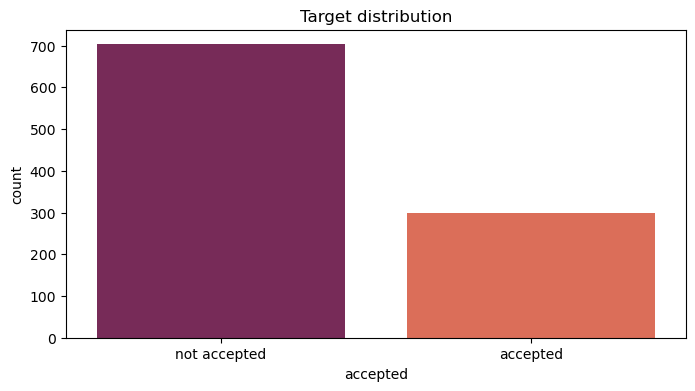

In [17]:
# Target distribution

# Plot
plt.figure(figsize = (8,4))
sns.countplot(data=df, x=df['accepted'], palette='rocket')
plt.title('Target distribution')
plt.xticks(ticks=[0,1], labels=['not accepted', 'accepted'])

# Show
plt.show()

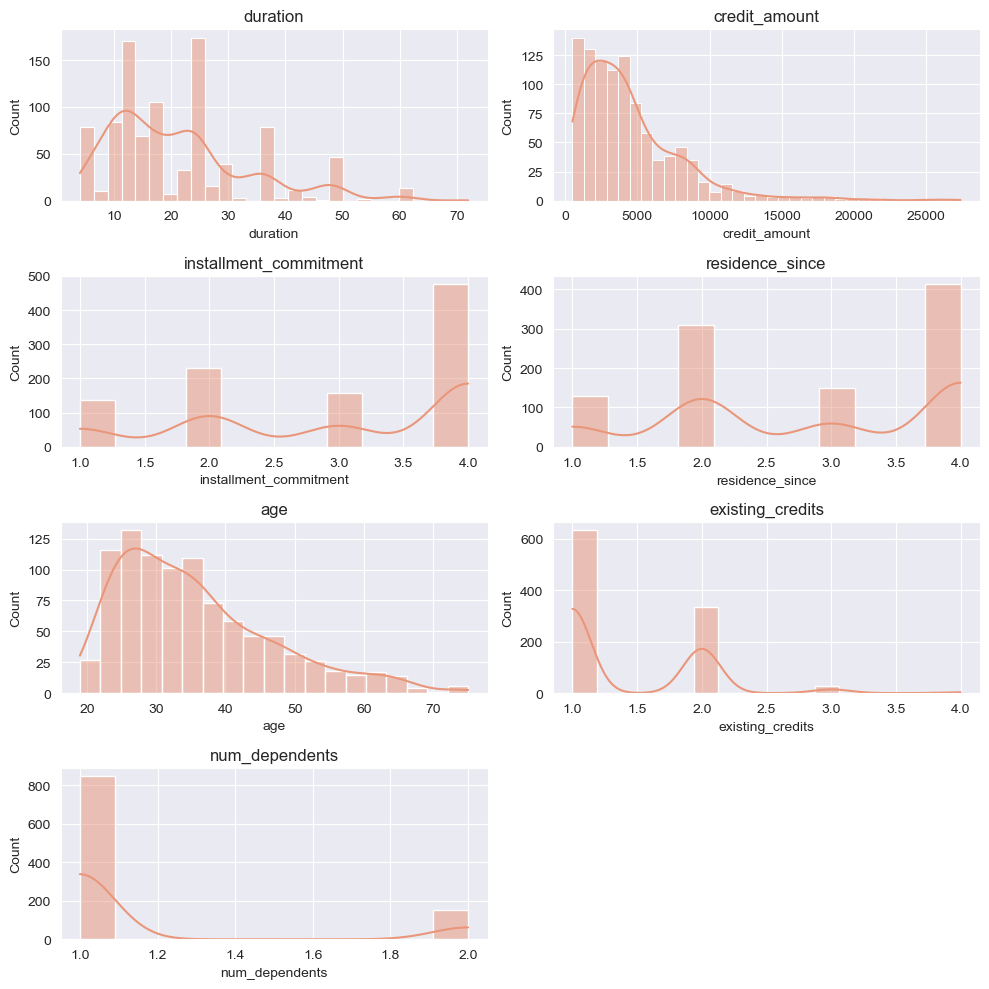

In [44]:
# Histograms of numerical columns

# Define subplots
sns.set_style('darkgrid')
fig,axs = plt.subplots(ncols=2, nrows = 4, figsize = (10,10))
axs = axs.ravel()

# Loop through the columns and plot
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], ax=axs[i], kde=True, color='darksalmon')  
    axs[i].set_title(col)
    
# Remove any unused subplots
for j in range(len(numerical_columns), len(axs)):
    axs[j].axis('off')

# Show
plt.tight_layout()
plt.show()

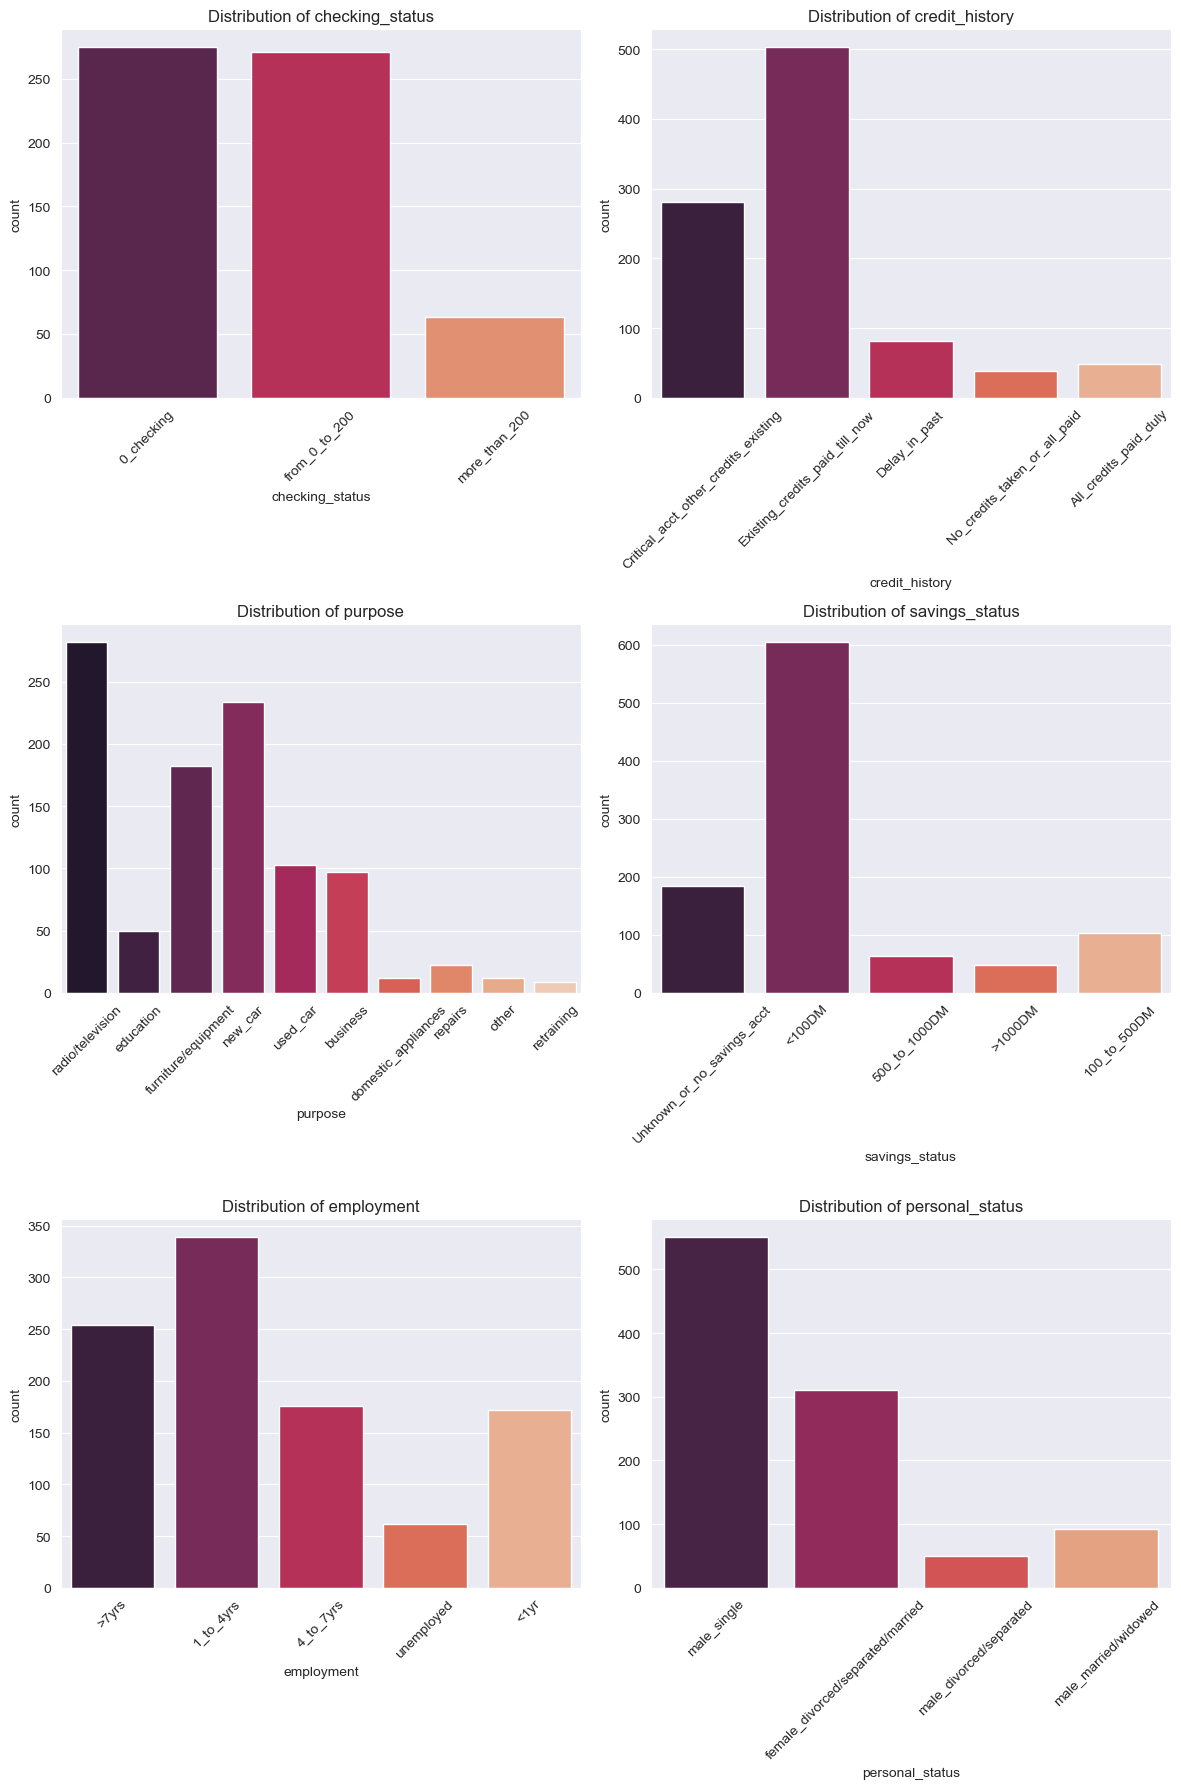

In [19]:
# Barplots for first 6 categorical features

# Define subplots
fig,axs = plt.subplots(ncols=2, nrows = 3, figsize = (12,18))
axs = axs.ravel()  

# Loop through the columns and plot
for i, col in enumerate(categorical_columns[:6]):
    sns.countplot(x=col, data=df, ax=axs[i], palette='rocket')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].tick_params(axis='x', rotation=45)

# Show
plt.tight_layout()
plt.show()

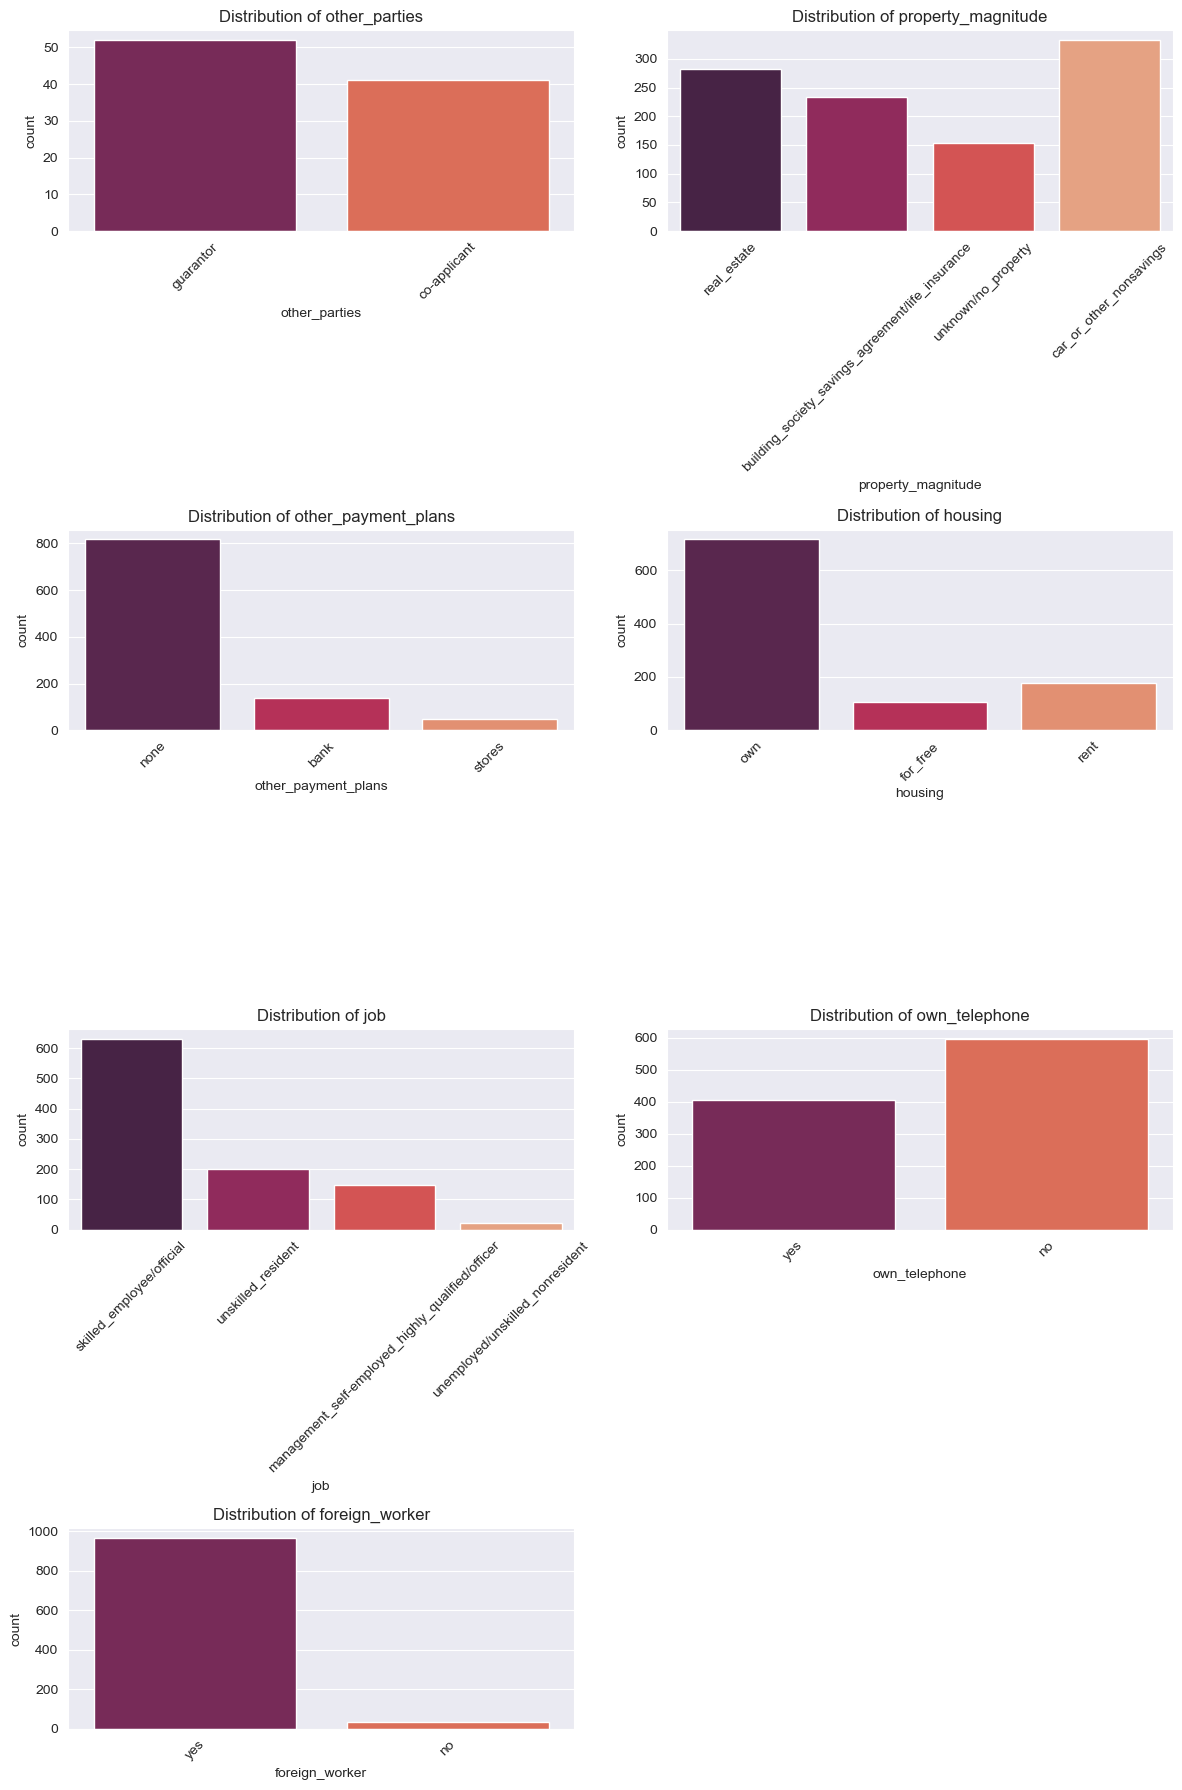

In [46]:
# Barplots for categorical features for other half 

# Define subplots
fig,axs = plt.subplots(ncols=2, nrows = 4, figsize = (12,18))
axs = axs.ravel()  

# Loop through the columns and plot
for i, col in enumerate(categorical_columns[6:]):
    sns.countplot(x=col, data=df, ax=axs[i], palette='rocket')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].tick_params(axis='x', rotation=45)
    
# Remove any unused subplots
for j in range(len(categorical_columns[6:]), len(axs)):
    axs[j].axis('off')

# Show
plt.tight_layout()
plt.show()

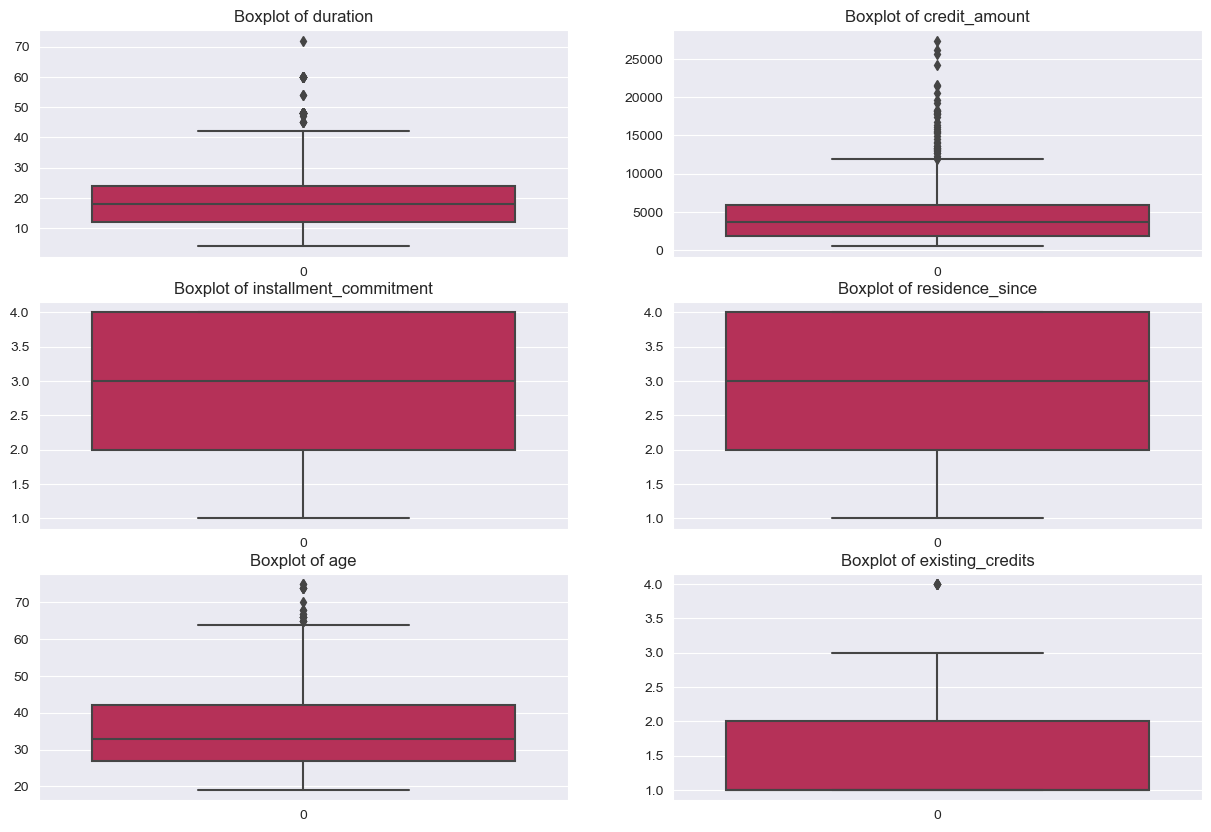

In [49]:
# Detecting outliers (except features accepted and num_dependents because they are binary)  

# Define subplots
fig,axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15,10))
axs = axs.ravel()

# Loop throught the columns and plot
for i,col in enumerate(numerical_columns[:6]):
    sns.boxplot(df[col], ax=axs[i], palette='rocket')
    axs[i].set_title(f'Boxplot of {col}')

    
# Show
plt.show()

## Conclusion from Univariate Analysis:


### Target Variable
- **Imbalance:** The target variable is not balanced, with more not approved credits than approved credits.

### Numerical Features
- **Credit Amount:** The distribution is skewed to the right, indicating a larger number of lower credit amounts with a few very high ones.
- **Installment Commitment:** There are only four values (1, 2, 3, 4) with the highest bar at 4, indicating that most individuals have higher installment commitments, suggesting that many borrowers are taking on larger loans that require higher monthly payments.
- **Residence Since:** There are four values (1, 2, 3, 4), with the highest at 4 yrs, followed by 2, 3, and 1 year. This could imply that longer residency is associated with higher creditworthiness.
- **Age:** The distribution is skewed to the right with the highest bars between 25 and 40, indicating that most borrowers are within this age range.
- **Existing Credits:** There are four values (1, 2, 3, 4) with the highest bar at 1 existing credit, followed by 2, and very low at 3 and 4, indicating that most individuals have fewer existing credits.
- **Number of Dependents:** There are two values (1, 2) with the highest bar at 1, suggesting most borrowers have fewer dependents.
- **Duration:** Exhibits an uneven distribution with fluctuating peaks and a slight rightward skew.

### Categorical Features
- **Checking Status:** The categories '0 checking' and 'from 0 to 200' have the highest bars, slightly higher for '0 checking'. 'More than 200' is more than half lower than the highest bars, suggesting that individuals with lower checking balances are more common in the dataset.
- **Credit History:** 'Existing credits paid till now' has the highest bar, followed by 'Critical account/other credits existing'. Other categories are much lower, indicating a history of credit payments is common.
- **Purpose:** 'Radio/television' has the highest bar, followed by 'new car', 'furniture/equipment', 'used car', and 'business'. 'Education' and other categories are the lowest, suggesting loans are commonly taken for consumer goods.
- **Savings Status:** The highest bar is '<100 DM (Deutsche marks)', with other categories significantly lower, indicating most borrowers have low savings.
- **Employment:** The highest bar is '1 to 4 years', followed by '>7 years'. '4 to 7 years' and '<1 year' are nearly the same height, indicating a varied employment history among borrowers.
- **Personal Status:** 'Male single' has the highest bar, followed by 'female divorced/separated/married'. Other categories are lower.
- **Other Parties:** The 'Guarantor' category has the highest count, followed by 'co-applicant,' indicating that guarantors are more common than co-applicants. Additionally, it is important to note that there are 910 missing values in this feature.
- **Property Magnitude:** 'Car or other non-savings' is the highest, followed by 'real estate'. Other categories are lower, suggesting borrowers have more non-savings assets.
- **Other Payment Plans:** 'None' has the highest bar, with 'bank' and 'stores' being slightly lower, indicating that most borrowers do not have other payment plans.
- **Housing:** 'Own' is the highest, followed by 'rent' and 'for free', indicating home ownership is common among borrowers.
- **Job:** 'Skilled employee/official' has the highest bar. This indicates that mostly they are employed.
- **Own Telephone:** The highest bar is at 'no', possibly indicating an older dataset since Deutsche marks are mentioned.
- **Foreign Worker:** 'Yes' is the highest, with 'no' being very low, suggesting most borrowers are foreign workers.


### Outliers
- **Credit Amount:** This feature contains the highest number of outliers.
- **Duration** and **Age**: This features have some outliers, though fewer than the Credit Amount.
- **Existing Credits:** This feature has one/two outliers.


### b) Bivariate and Multivariate Analysis

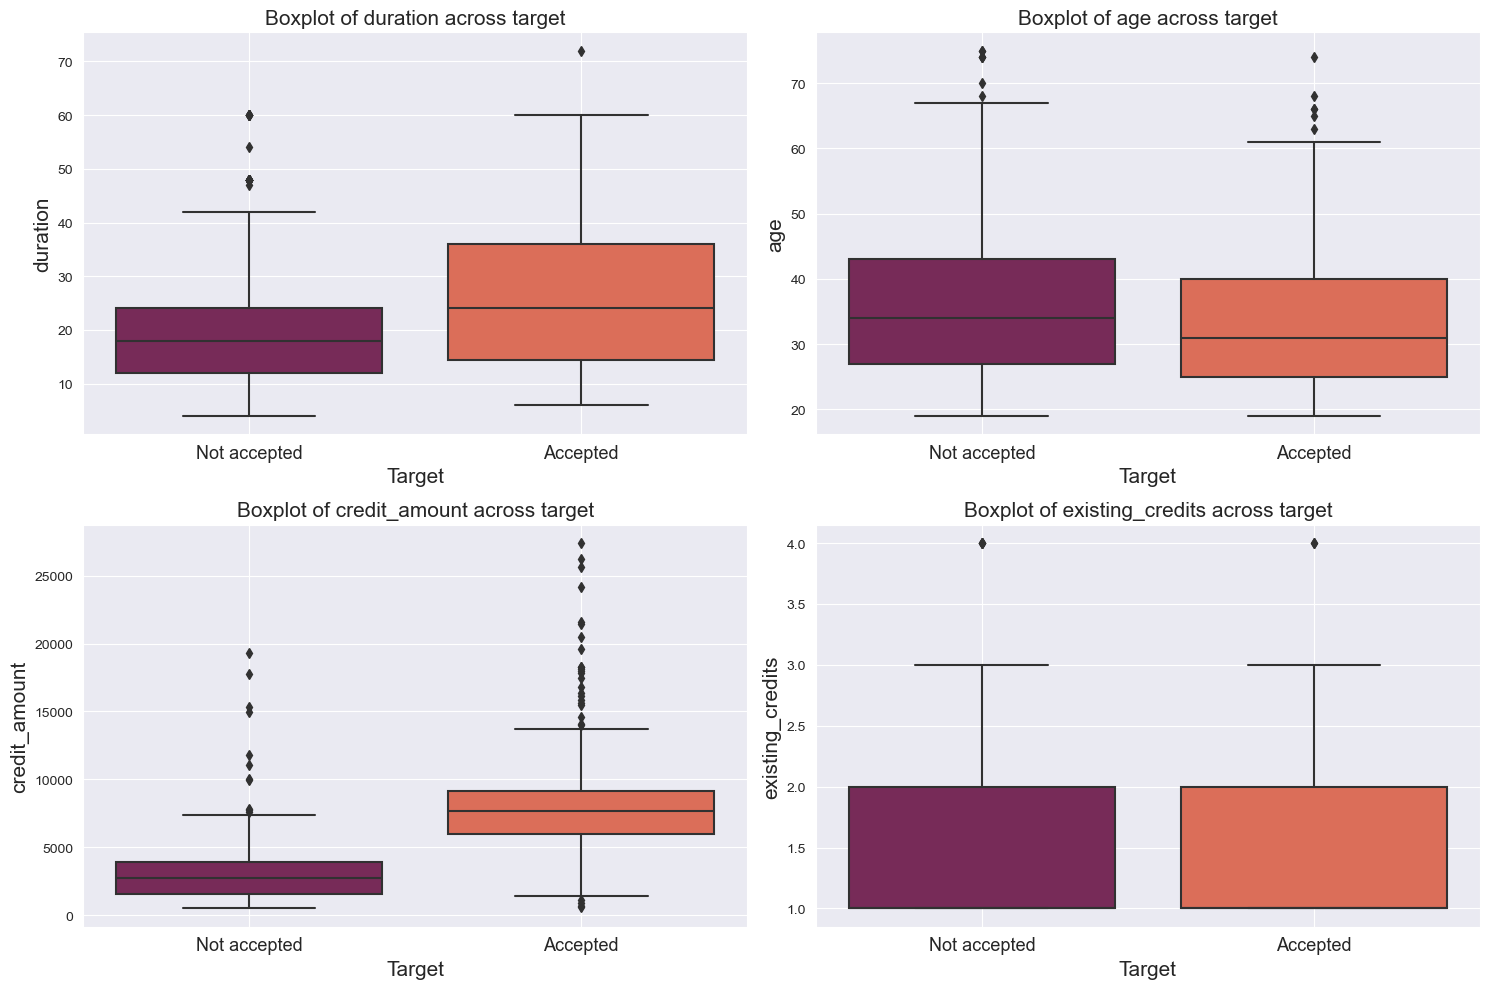

In [50]:
# Analyzing outliers across target column

# Define columns
cols = ['duration','age','credit_amount','existing_credits']

# Define subplots
figs, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
axs = axs.ravel()  

# Loop through the columns and plot
for i, col in enumerate(cols):
    sns.boxplot(x='accepted', y=col, data=df, palette='rocket', ax=axs[i])
    axs[i].set_title(f'Boxplot of {col} across target', fontsize = 15)
    axs[i].set_xticks(ticks = [0,1], labels = ['Not accepted', 'Accepted'], fontsize = 13)
    axs[i].set_xlabel(xlabel = 'Target', fontsize = 15)
    axs[i].set_ylabel(ylabel = f'{col}', fontsize = 15)
    axs[i].grid(True)
    

# Show
plt.tight_layout()
plt.show()

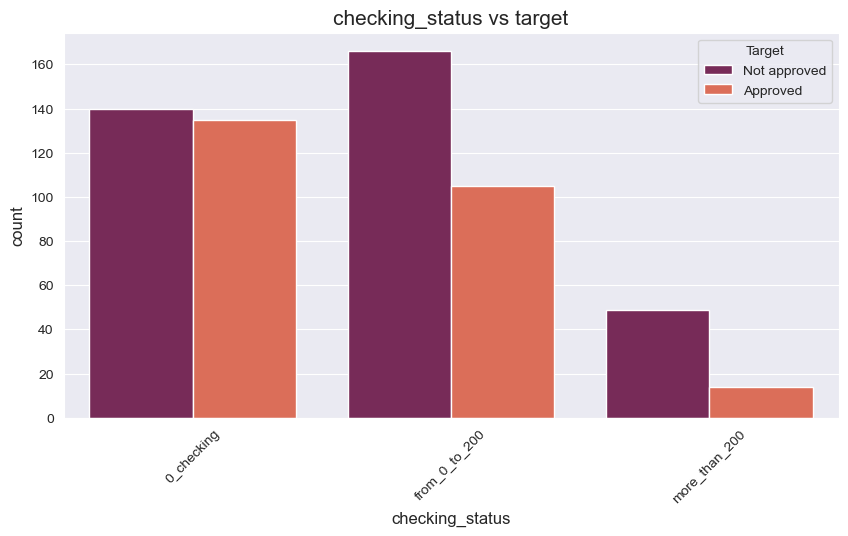

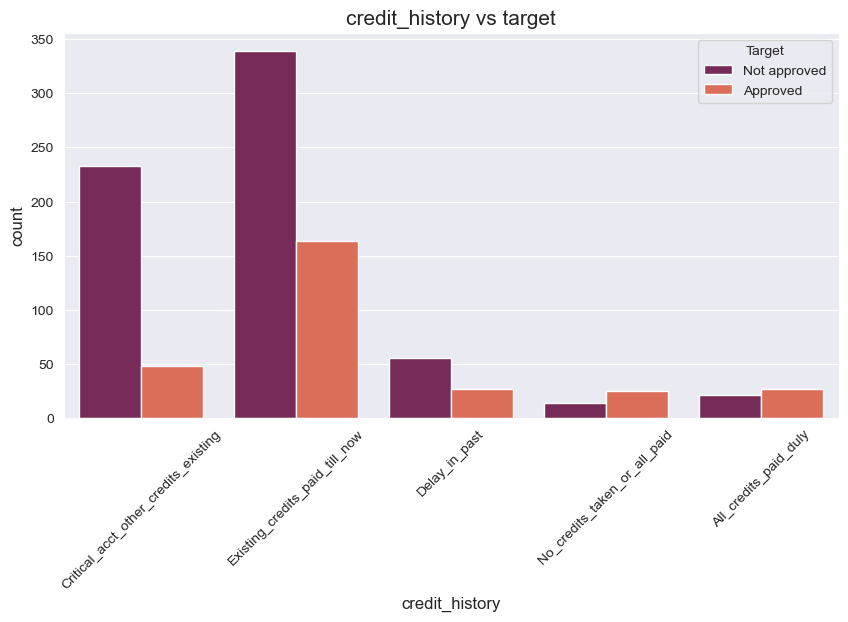

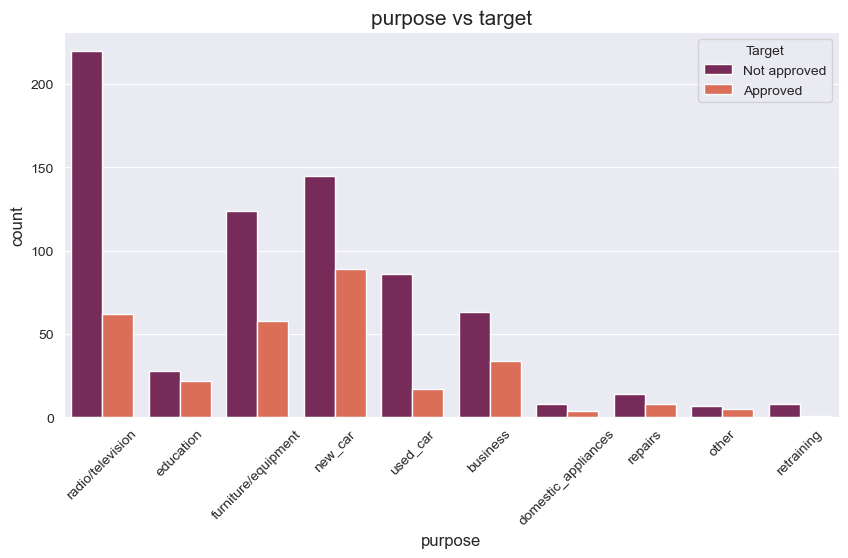

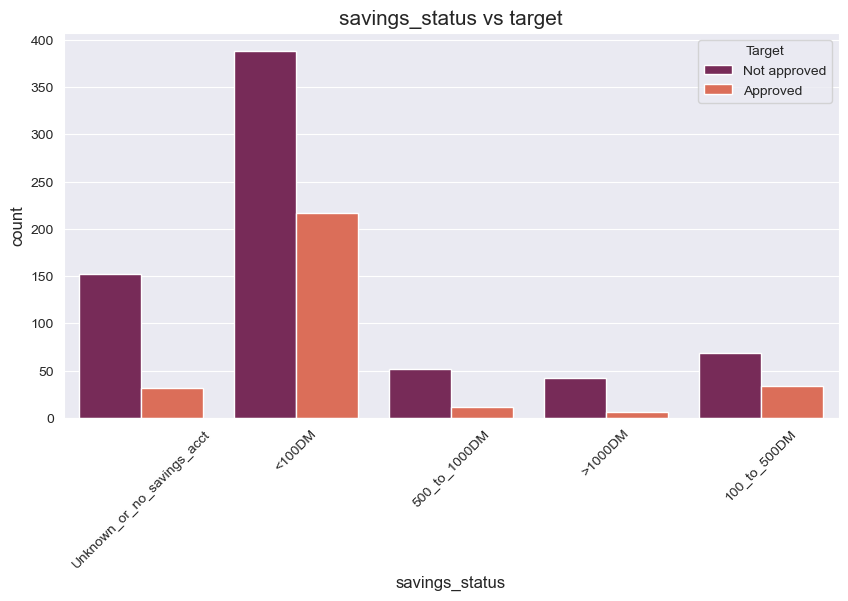

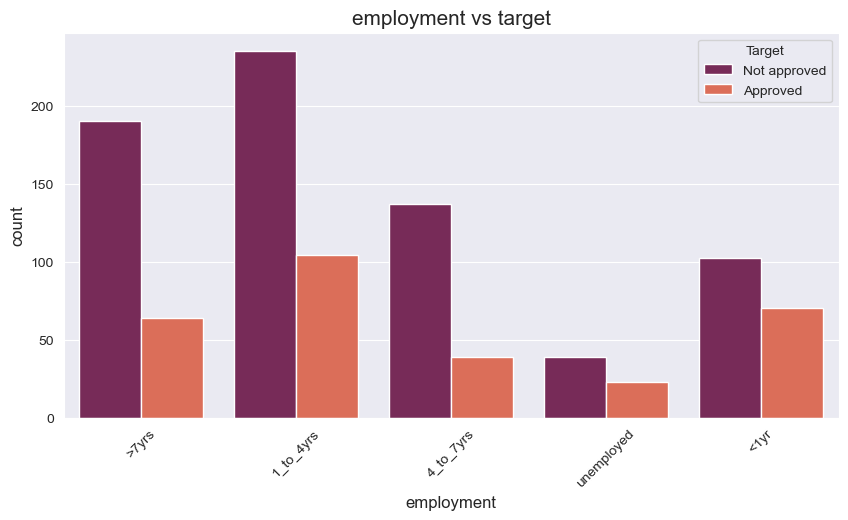

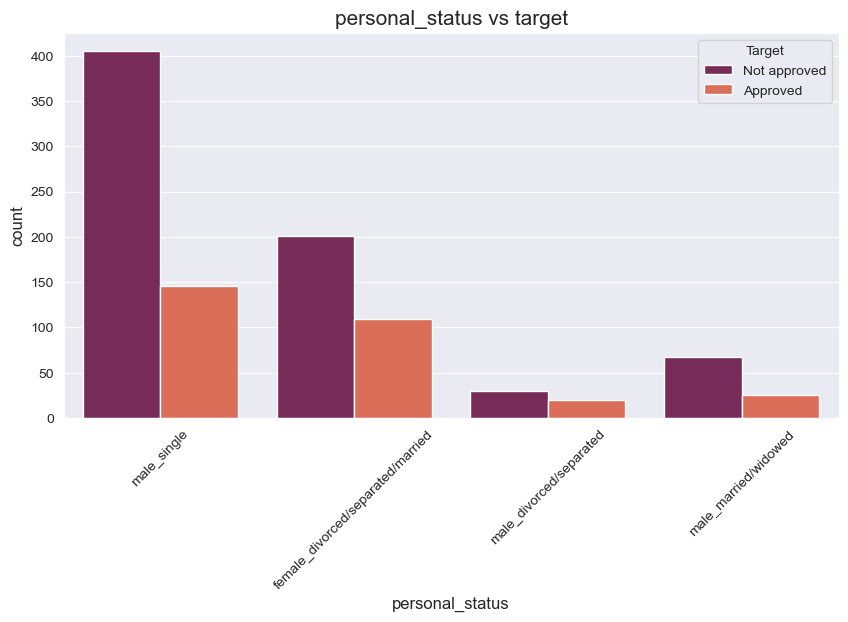

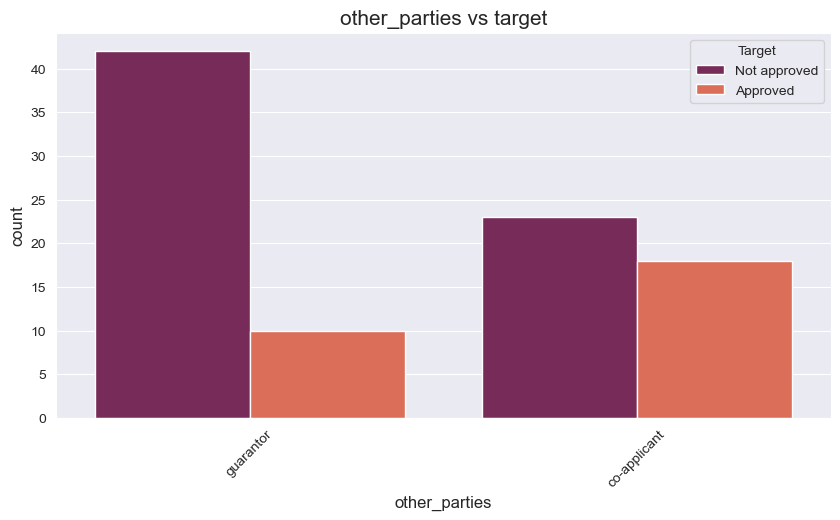

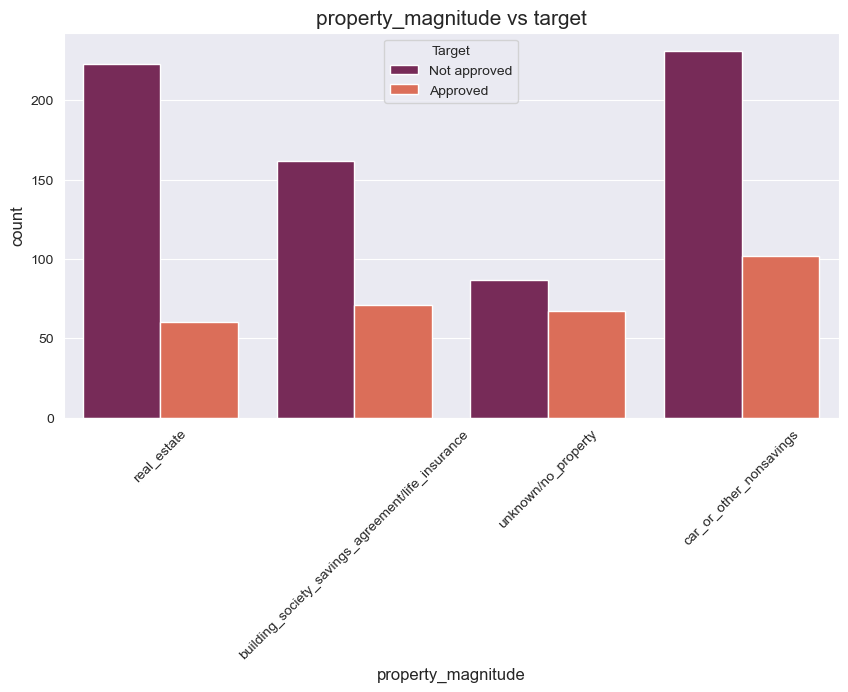

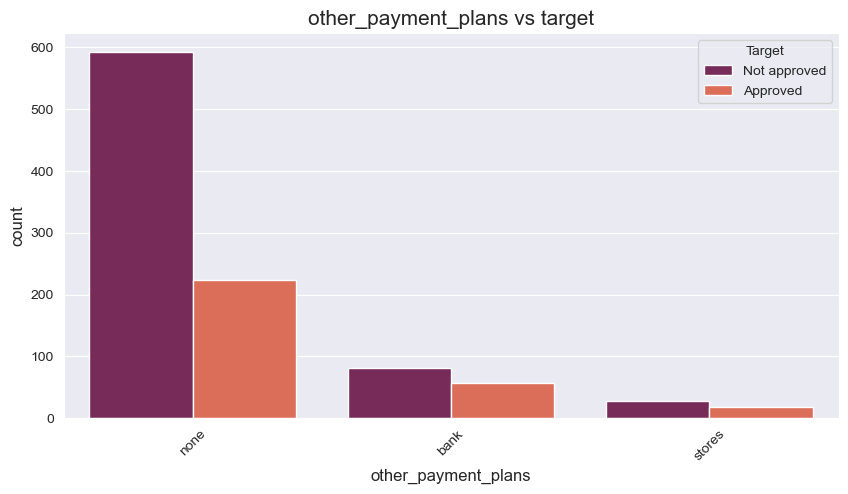

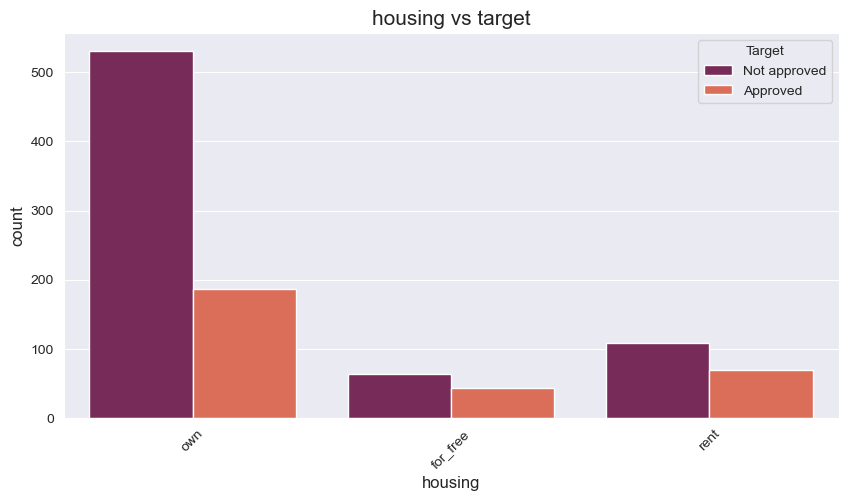

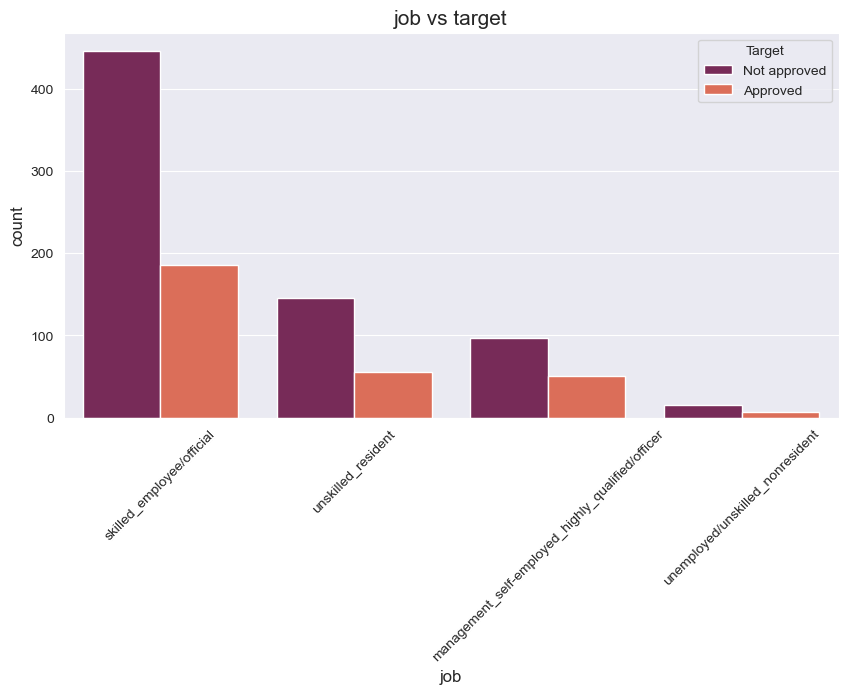

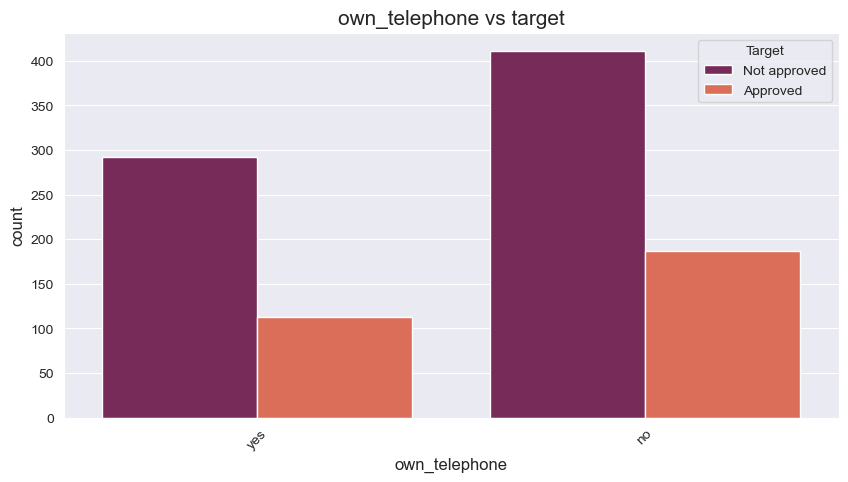

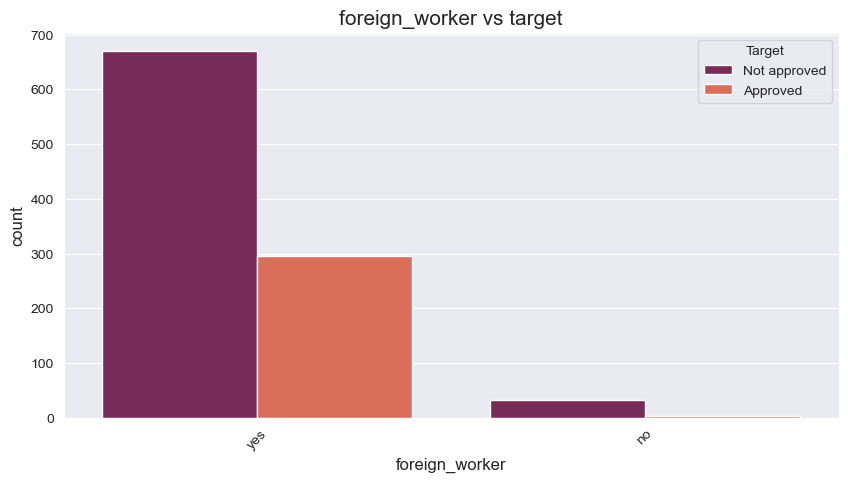

In [23]:
# Analyzing categorical columns vs target categories

# Loop through all categorical features
for col in categorical_columns:
    plt.figure(figsize = (10,5))
    sns.countplot(data = df, x=col, hue='accepted', palette='rocket')
    plt.title(f'{col} vs target', fontsize = 15)
    plt.xlabel(col, fontsize = 12)
    plt.ylabel('count', fontsize = 12)
    plt.legend(['Not approved','Approved'], title='Target', loc = 'best')
    plt.xticks(rotation = 45)

    # Show
    plt.show()

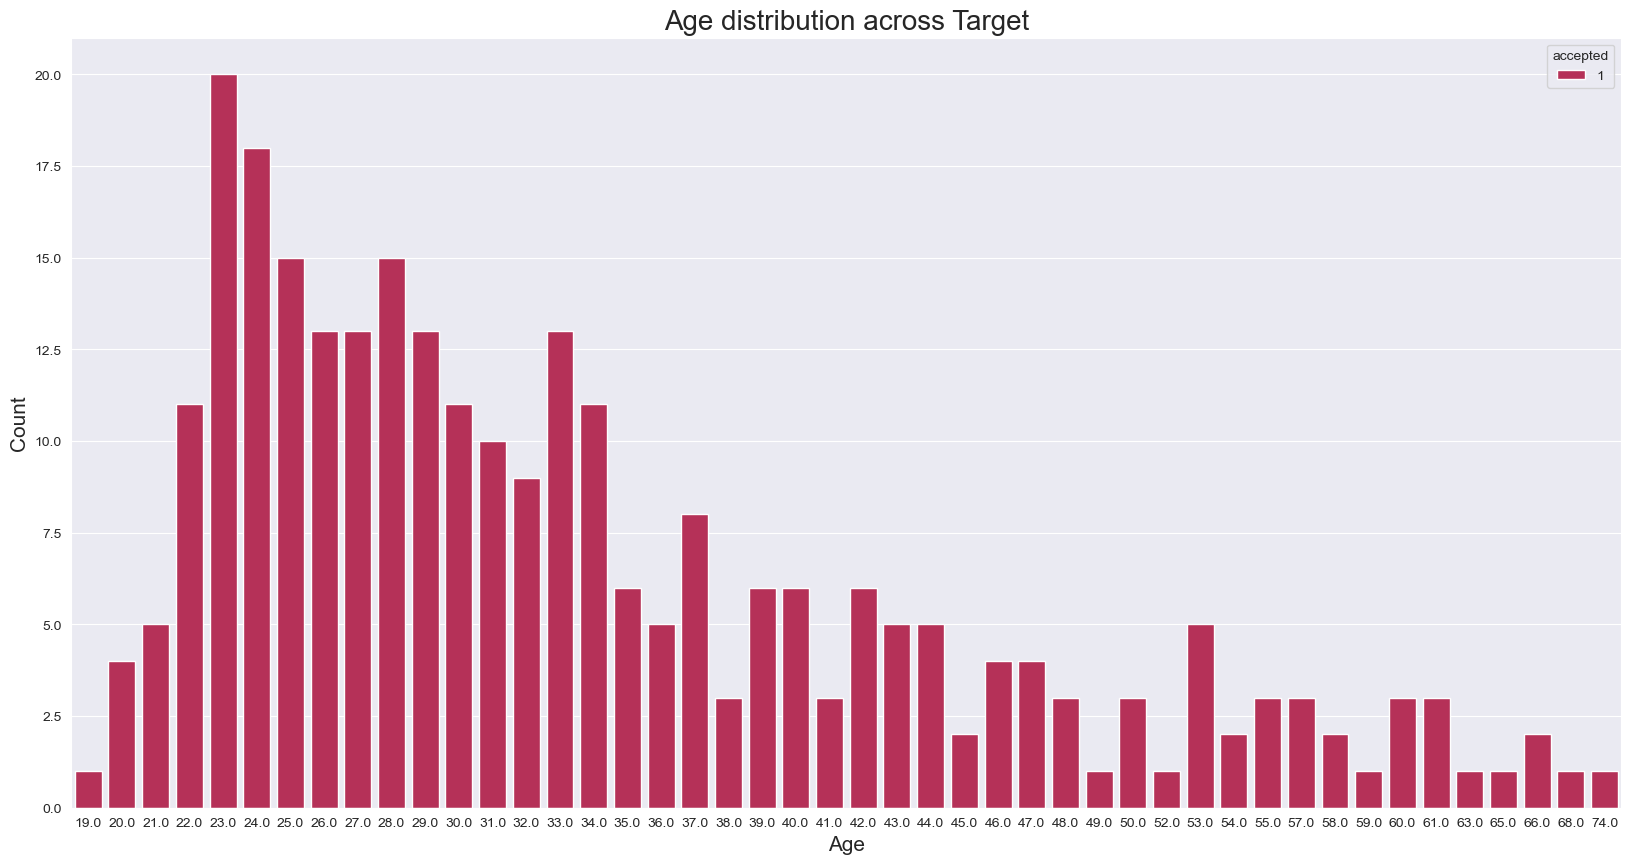

In [24]:
# Age vs approved credit
df_age = df[df['accepted'] == 1].sort_values(by = 'age', ascending=False)

# Plot
plt.figure(figsize = (20,10))
sns.countplot(data = df_age, x = 'age',hue = 'accepted', palette='rocket')
plt.title('Age distribution across Target', fontsize = 20)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

# Show
plt.show()

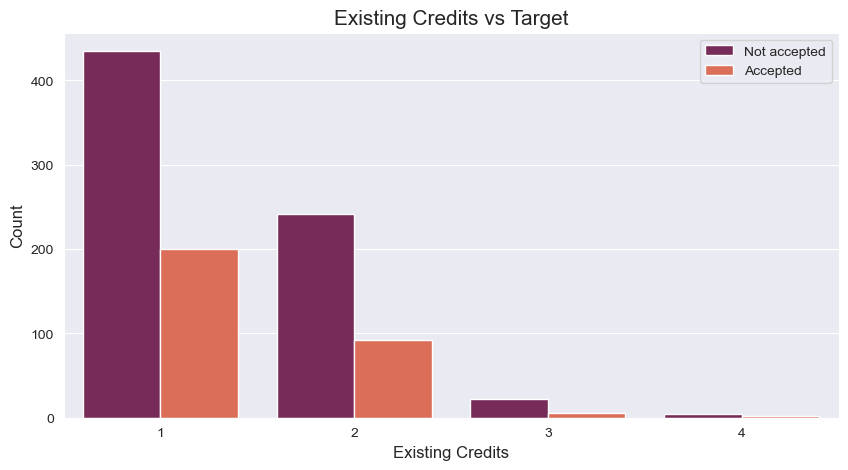

In [25]:
# Existing Credits vs Target

# Plot
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = 'existing_credits',hue = 'accepted', palette='rocket')
plt.title('Existing Credits vs Target', fontsize = 15)
plt.xlabel('Existing Credits', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.legend(labels = ['Not accepted', 'Accepted'])

# Show
plt.show()

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


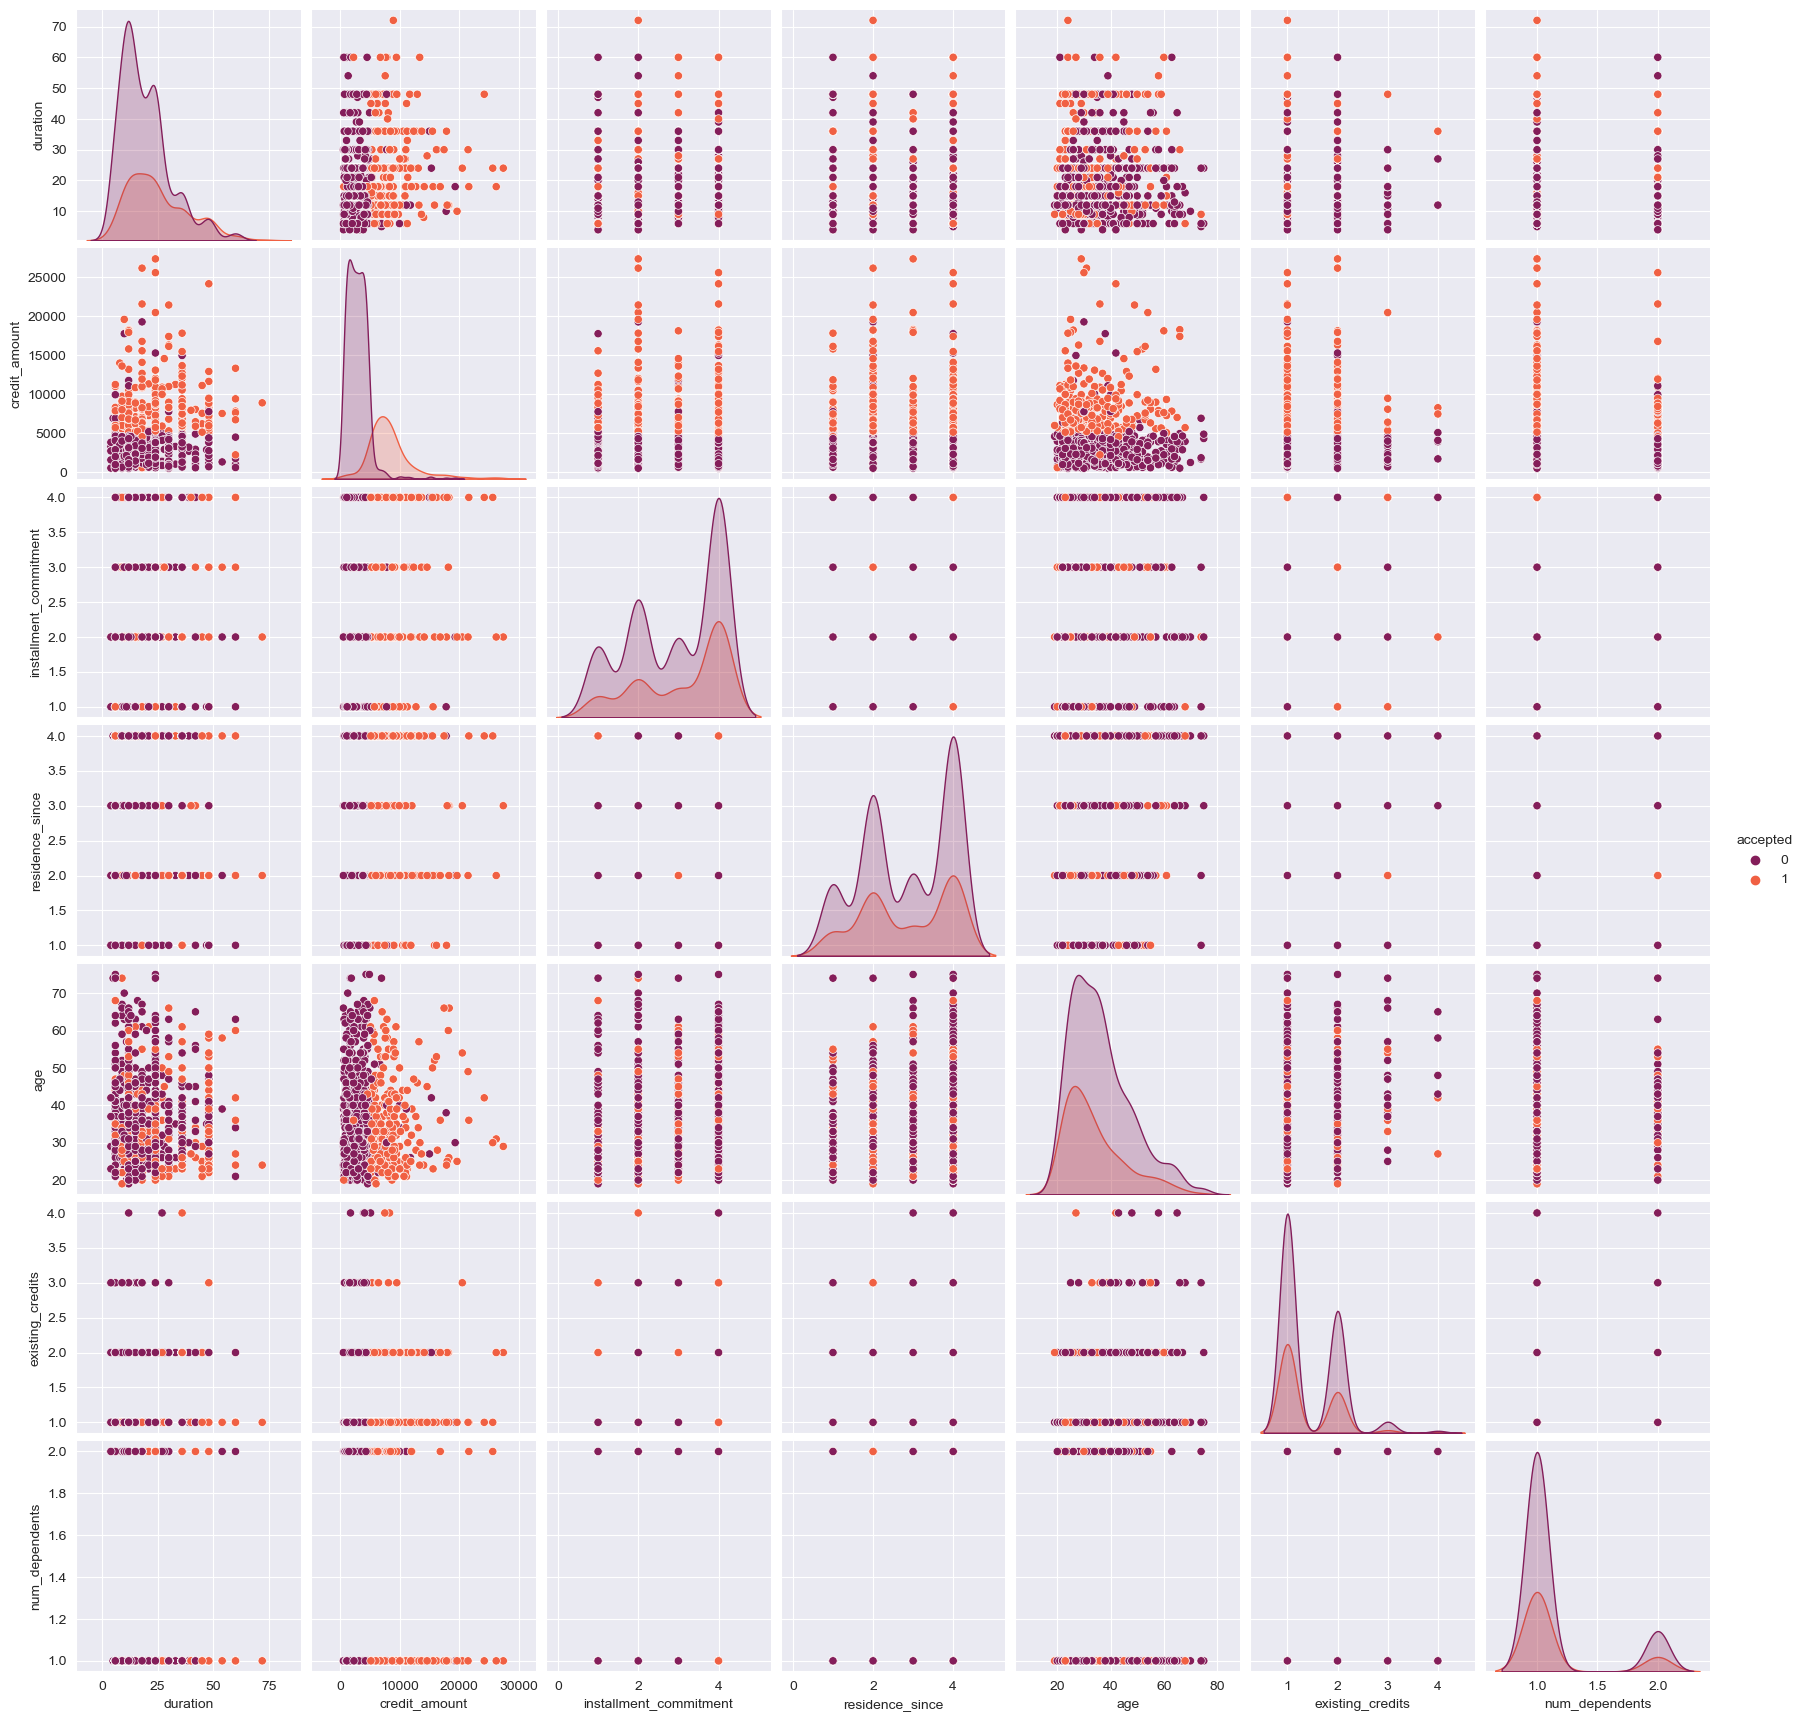

In [26]:
# Paitplot
sns.pairplot(df, hue='accepted', palette='rocket')

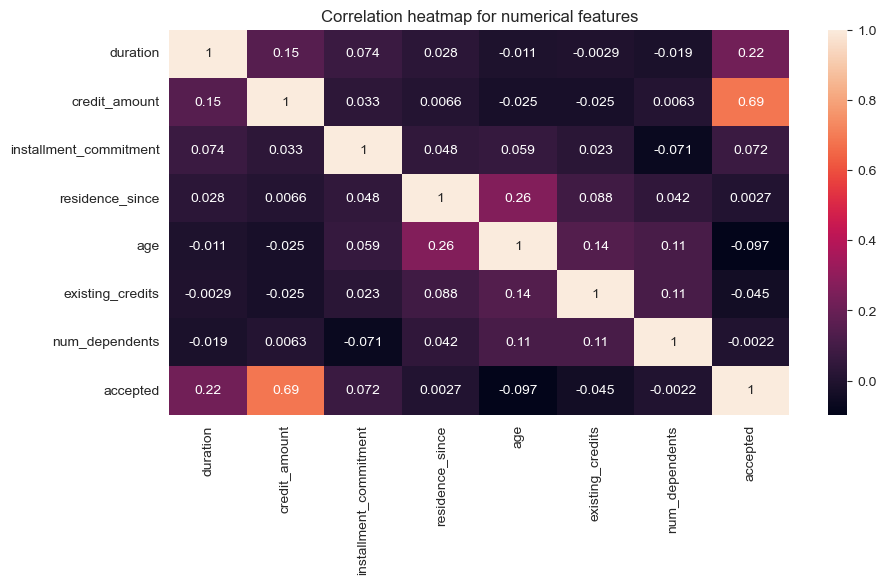

In [27]:
# Correlation heatmap for numerical features
df_corr = df.corr(numeric_only=True)

# Plot
plt.figure(figsize = (10,5))
sns.heatmap(df_corr, annot=True, cmap = 'rocket')
plt.title('Correlation heatmap for numerical features')

# Show
plt.show()


In [28]:
# Chi2 score for categorical features vs target for their correlation

for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['accepted'])
    chi2_g, p_g, dof_g, expected_g = chi2_contingency(contingency_table)

    print(f'Chi2 Statistic for {col}: {chi2_g.round(2)}')
    print(f'P-value for {col}: {p_g.round(5)}\n')

Chi2 Statistic for checking_status: 16.98
P-value for checking_status: 0.00021

Chi2 Statistic for credit_history: 60.89
P-value for credit_history: 0.0

Chi2 Statistic for purpose: 33.75
P-value for purpose: 0.0001

Chi2 Statistic for savings_status: 36.07
P-value for savings_status: 0.0

Chi2 Statistic for employment: 18.91
P-value for employment: 0.00082

Chi2 Statistic for personal_status: 9.9
P-value for personal_status: 0.01948

Chi2 Statistic for other_parties: 5.51
P-value for other_parties: 0.0189

Chi2 Statistic for property_magnitude: 23.94
P-value for property_magnitude: 3e-05

Chi2 Statistic for other_payment_plans: 13.07
P-value for other_payment_plans: 0.00145

Chi2 Statistic for housing: 18.55
P-value for housing: 9e-05

Chi2 Statistic for job: 1.97
P-value for job: 0.57836

Chi2 Statistic for own_telephone: 1.15
P-value for own_telephone: 0.28312

Chi2 Statistic for foreign_worker: 5.77
P-value for foreign_worker: 0.01628



## Conclusion from Bivariate and Multivariate Analysis:

### Analysis from Boxplots vs Target:
- **Duration Across Target**: 
   - For negative class: There are more outliers in this class, starting from 45 months above.
   - For positive class: Only one outlier detected, start from around 70 month.
- **Age Across Target:**
  - For negative class: Outliers start from around 67 years and above.
  - For positive class: Outliers start from around 62 years and above.
- **Credit Amount Across Target:**
  - Mostly outliers in positive class starting from around 15,000, but there are more in negative class starting around 75,000.
- **Existing Credits Across Target:**
  - One outlier in both classes at value 4 existing credits.

### Categorical Columns vs Target Categories:
- **Checking Status:** 
  - Negative class: Highest at 'from 0 to 200'.
  - Positive class: Highest at '0 checking'.
- **Credit History:** 
  - Both classes: Highest at 'existing credits paid till now'.
- **Purpose:** 
  - Negative class: Highest at 'radio/television'.
  - Positive class: Highest at 'new car'.
- **Savings Status:** 
  - Both classes: Highest at '<100DM'.
- **Employment:** 
  - Both classes: Highest at '1 to 4 years'.
- **Personal Status:** 
  - Both classes: Highest at 'male single'.
- **Other Parties:** 
  - Negative class: Highest at 'guarantor'.
  - Positive class: Highest at 'co-applicant'.
- **Property Management:** 
  - Both classes: The highest frequency is seen in 'car or other nonsavings' category.
- **Other Payment Plans:** 
  - Both classes: The most common value is 'none'.
- **Housing:** 
  - Both classes: The most common value is 'own'.
- **Job:** 
  - Both classes: The most common value is  'skilled_employee/official'.
- **Own Telephone:** 
  - Both classes: The most common value is 'no'.
- **Foreign Worker:** 
  - Both classes: The most common value is 'yes'.

### Age vs Approved Target:
- The age distribution shows the highest concentration of individuals between 22 and 37 years old. Beyond 37, the age range extends up to 74, exhibiting fluctuations, which suggests that other factors may influence this distribution.

### Existing Credits vs Target:
- Both classes: Highest value for 1 credit.

### Correlation Heatmap for Categorical:
- The highest correlation with the target variable is found in the `credit_amount` feature, with a correlation coefficient of 0.69. 
- Second highest correlation with the target variable is found in the `duration` feature, with a correlation coefficient of 0.22.
- Other features show very low correlations with the target, ranging from 0.072 to -0.045.
- Inter-feature correlations are generally low, with the highest being between age and residence_since at 0.26.

### Analysis of Pairwise Relationships

The pairwise relationships between variables in the dataset reveal intriguing distributions and correlations, particularly involving `credit_amount`. This suggests that credit_amount might be a **key predictor** in the predictive model.

From the pairplot, it is evident that only lower credit amounts were approved for credit, while almost all larger credit amounts were not approved. This indicates a strong relationship between 'credit_amount' and credit approval status, highlighting its potential importance in predicting creditworthiness.

### Correlation for Numerical Columns:
 - Highest correlation with target are:

      **Credit History:**
    
     `Chi2 Statistic: 60.89`
     
     `P-value: 0.0`
     
     The credit history feature has a chi-square statistic of 60.89 with the target variable, suggesting a notable association.      The p-value of 0.0 supports the significance of this correlation.

### Detailed Analysis od Credit Amount Outliers

In [29]:
# Calculating outliers for feature credit amount usng mean and std
mean = df['credit_amount'].mean()
std_dev = df['credit_amount'].std()

# Define the thresholds for outliers
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Identify outliers
outliers = df[(df['credit_amount'] < lower_bound) | (df['credit_amount'] > upper_bound)]
print('Number of detected outliers in feature credit_amount:', len(outliers))

Number of detected outliers in feature credit_amount: 22


In [30]:
outliers['credit_amount'].describe()[['min','max']]

min    15490.0
max    27389.0
Name: credit_amount, dtype: float64

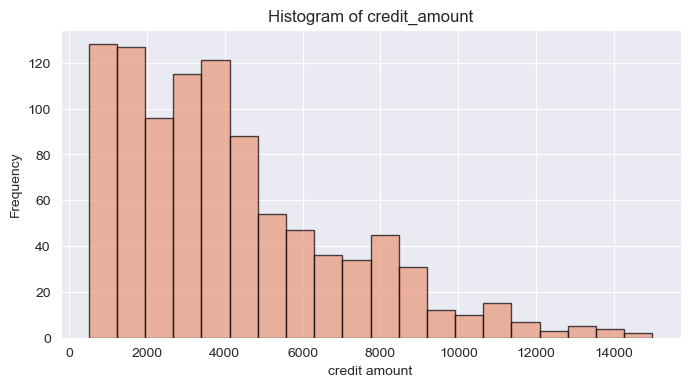

In [31]:
# Histogram of credit amount where credit amount < 15000

# define data
df_filtered = df[df['credit_amount'] < 15000]

# Plot
plt.figure(figsize=(8, 4))
plt.hist(df_filtered['credit_amount'], bins=20, edgecolor='k', alpha=0.7, color='darksalmon')
plt.title('Histogram of credit_amount')
plt.xlabel('credit amount')
plt.ylabel('Frequency')

# Show
plt.show()

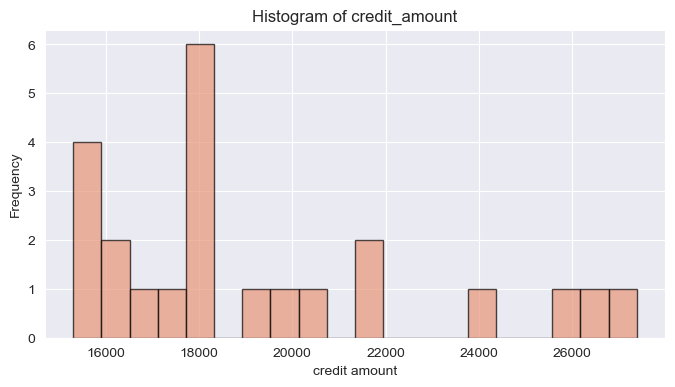

In [32]:
# Histogram of credit amount where credit amount > 15000

# define data
df_filtered = df[df['credit_amount'] > 15000]

# Plot
plt.figure(figsize=(8, 4))
plt.hist(df_filtered['credit_amount'], bins=20, edgecolor='k', alpha=0.7, color='darksalmon')
plt.title('Histogram of credit_amount')
plt.xlabel('credit amount')
plt.ylabel('Frequency')

# Show
plt.show()

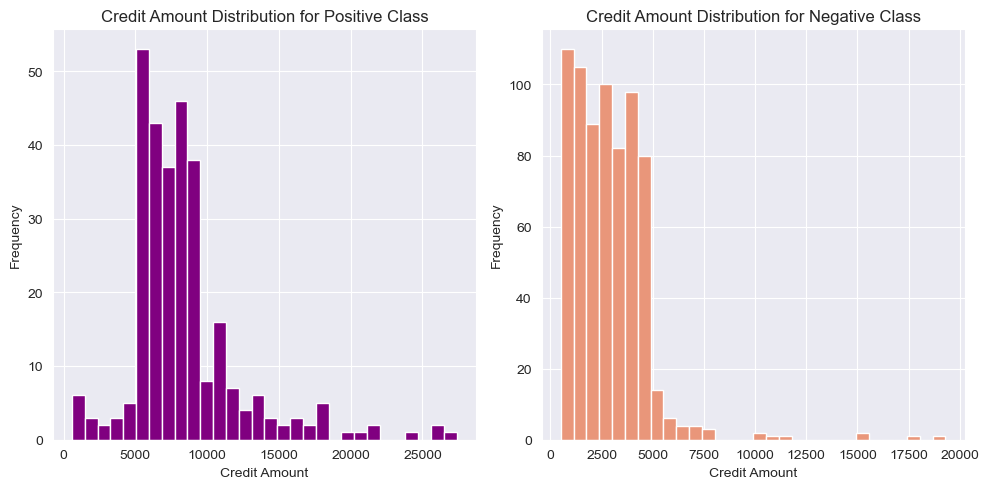

In [33]:
df_credit_1 = df[df['accepted'] == 1]
df_credit_0 = df[df['accepted'] == 0]

# Define subplots
fig,axs = plt.subplots(ncols = 2, nrows =1, figsize = (10,5))
axs = axs.ravel()

# Histogram for diabetics
axs[0].hist(df_credit_1['credit_amount'], color='purple', bins=30)
axs[0].set_title('Credit Amount Distribution for Positive Class')
axs[0].set_xlabel('Credit Amount')
axs[0].set_ylabel('Frequency')

# Histogram for non-diabetics
axs[1].hist(df_credit_0['credit_amount'], color='darksalmon', bins=30)
axs[1].set_title('Credit Amount Distribution for Negative Class')
axs[1].set_xlabel('Credit Amount')
axs[1].set_ylabel('Frequency')

# Show 
plt.tight_layout()
plt.show()

## Outlier Analysis of Credit Amount

A detailed analysis of the outliers in the `credit_amount` feature reveals that outliers begin to appear from around 14,900. Histograms indicate that up to 15,000, the distribution is skewed with a right tail. Beyond 15,000, the distribution becomes uneven, with fluctuations and some gaps in the values.

When comparing the histogram of **credit_amount against the target variable**, we observe that `approved credits exhibit a roughly normal distribution within the range of 0 to 15,000`. In contrast, `for the negative class (non-approved credits), the distribution is more uniform from 0 to 4,500`, decreases significantly at 5,000, and then shows a fluctuating pattern up to 20,000.

**Given that 'credit_amount' demonstrates the highest correlation with the target, I will not make adjustments to this feature. Instead, I will employ models that are robust to outliers and capable of handling imbalanced data.**

_________________


## Data Splitting


In [34]:
# Splitting on dependent (y) and independent feature (X)
X = df.drop(columns=['accepted'])
y = df['accepted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,stratify=y, random_state=42)

# Shape
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (802, 20)
y_train shape: (802,)
X_test shape: (201, 20)
y_test shape: (201,)


## Data Preprocessing

In [35]:
# Drop target 
numerical_columns = numerical_columns.drop('accepted')

In [36]:
# Missing values
print('Missing values percentage:\n', missing_values.sort_values(ascending=False))

Missing values percentage:
 other_parties      90.727817
checking_status    39.282154
duration            5.284148
credit_history      4.985045
age                 4.985045
dtype: float64


In [37]:
# Class for dropping columns with nan values greate than 10%
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        columns_to_drop = [col for col in self.columns_to_drop if col in X_df.columns]
        X_df = X_df.drop(columns=columns_to_drop, errors='ignore')
        return X_df.to_numpy()

In [51]:
# Defining pipelines for categorical and numerical features
categorical_pipe = Pipeline(steps = [
                            ('drop_columns', DropColumnsTransformer(columns_to_drop=['other_parties','checking_status'])),
                            ('imputer', SimpleImputer(strategy='most_frequent')), #not the best way to impute 
                            ('encoder', OrdinalEncoder())])

numerical_pipe = Pipeline(steps = [
                                    ('imputer', KNNImputer(n_neighbors=5)),
                                    ('scaler', MinMaxScaler())
                                  ])

# Define preprocessor
preprocessor = ColumnTransformer([
                                  ('num', numerical_pipe, numerical_columns),
                                  ('cat', categorical_pipe, categorical_columns)
                                ])

## Model Training 

For this training, I will use models that are robust to outliers and less sensitive to imbalanced datasets, such as RandomForestClassifier and XGBClassifier. I will also experiment with SVM. Hyperparameters will be tuned manually, and GridSearch will be used to confirm if a better score can be achieved.

In [246]:
# List to store results
results = []

#### a) Random Forest Classifier

In [247]:
# Random Forest
pipe_rf = Pipeline(steps=[('preprocessing', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=10,max_depth=4,criterion = 'gini',
                                                         class_weight='balanced',random_state=SEED))])

# Fit
pipe_rf.fit(X_train,y_train)

# Cross Validate
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=SEED)
score_rf = cross_val_score(pipe_rf, X_train,y_train, scoring='f1', cv = skf, n_jobs=-1)

# Predict
y_pred_rf = pipe_rf.predict(X_test)
y_pred_rf_train = pipe_rf.predict(X_train)
# Evaluate
print('Cross-validate scores for Random Forest:', score_rf.round(3))
print('Mean Cross-validate score:', score_rf.mean().round(3))

print('\nF1 score on test set:', f1_score(y_test,y_pred_rf).round(3))
print('F1 score on train set:', f1_score(y_train,y_pred_rf_train).round(3))

# Classification Report
print('-----------------------------------------------------')
print('Classification Report:')
print('-----------------------------------------------------')
print(classification_report(y_test,y_pred_rf))

# Append results
results.append({'model': 'RF_manually', 'test score': f1_score(y_test,y_pred_rf).round(3), 
                'train score': f1_score(y_train,y_pred_rf_train).round(3)})

Cross-validate scores for Random Forest: [0.922 0.949 0.926 0.889 0.926]
Mean Cross-validate score: 0.923

F1 score on test set: 0.932
F1 score on train set: 0.937
-----------------------------------------------------
Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       141
           1       0.95      0.92      0.93        60

    accuracy                           0.96       201
   macro avg       0.96      0.95      0.95       201
weighted avg       0.96      0.96      0.96       201



<Figure size 700x700 with 0 Axes>

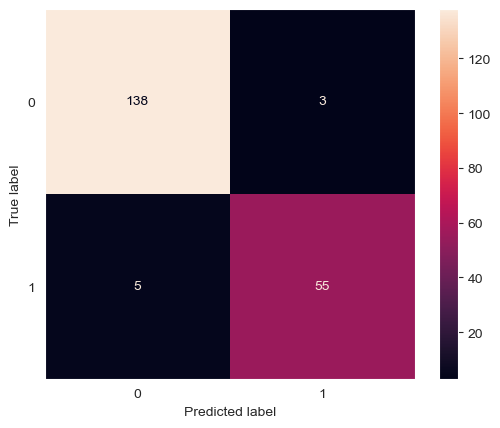

In [115]:
# Confusion Matrix for Random Forest

# Define confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
cf = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(7, 7))
cf.plot(cmap = 'rocket')
cf.ax_.grid(False)

# Show
plt.show()

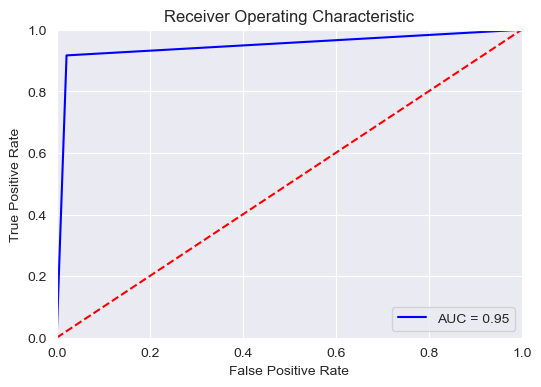

In [120]:
# ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize = (6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Show
plt.show()

#### b) XGB Classifier

In [249]:
# XGB Pipe
pipe_xgb = Pipeline(steps=[('preprocessing', preprocessor),
                          ('clf', XGBClassifier(n_estimators = 15,max_depth = 5,subsample = 0.5, colsample_bytree = 0.5,
                                                gamma = 3,random_state=SEED))])

# Fit
pipe_xgb.fit(X_train,y_train)

# Cross Validate
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=SEED)
score_xgb = cross_val_score(pipe_xgb, X_train,y_train, scoring='f1', cv = skf, n_jobs=-1)

# Predict
y_pred_xgb = pipe_xgb.predict(X_test)
y_pred_xgb_train = pipe_xgb.predict(X_train)

# Evaluate
print('Cross-validate scores for XGB:', score_xgb.round(3))
print('Mean Cross-validate score:', score_xgb.mean().round(3))

print('\nF1 score on test set:', f1_score(y_test,y_pred_xgb).round(3))
print('F1 score on train set:', f1_score(y_train,y_pred_xgb_train).round(3))

# Classification Report
print('-----------------------------------------------------')
print('Classification Report:')
print('-----------------------------------------------------')
print(classification_report(y_test,y_pred_xgb))

# Append results
results.append({'model': 'XGB_manually', 'test score': f1_score(y_test,y_pred_xgb).round(3), 
                'train score': f1_score(y_train,y_pred_xgb_train).round(3)})

Cross-validate scores for XGB: [0.922 0.939 0.969 0.889 0.903]
Mean Cross-validate score: 0.924

F1 score on test set: 0.924
F1 score on train set: 0.929
-----------------------------------------------------
Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       141
           1       0.93      0.92      0.92        60

    accuracy                           0.96       201
   macro avg       0.95      0.94      0.95       201
weighted avg       0.96      0.96      0.96       201



<Figure size 700x700 with 0 Axes>

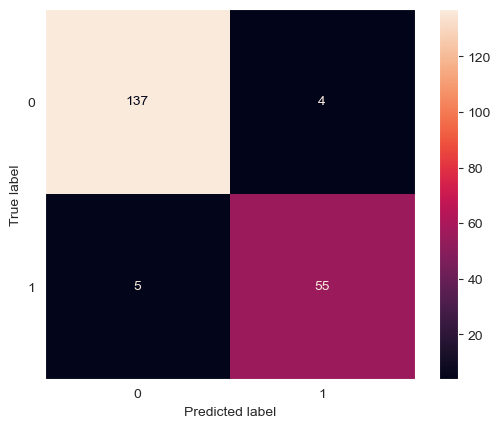

In [178]:
# Confusion Matrix for XGBoost

# Define confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
cf = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(7, 7))
cf.plot(cmap = 'rocket')
cf.ax_.grid(False)

# Show
plt.show()

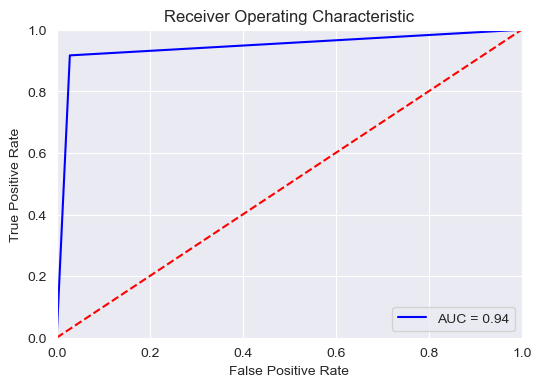

In [179]:
# ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize = (6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Show
plt.show()

#### c) SVC

In [250]:
# SVC
pipe_svc = Pipeline(steps=[('preprocessing', preprocessor),
                          ('clf', SVC(kernel = 'poly',degree = 3, C = 0.042,
                                      class_weight='balanced',random_state=SEED))])

# Fit
pipe_svc.fit(X_train,y_train)

# Cross Validate
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=SEED)
score_svc = cross_val_score(pipe_svc, X_train,y_train, scoring='f1', cv = skf, n_jobs=-1)

# Predict
y_pred_svc = pipe_svc.predict(X_test)
y_pred_svc_train = pipe_svc.predict(X_train)

# Evaluate
print('Cross-validate scores for SVC:', score_svc.round(3))
print('Mean Cross-validate score:', score_svc.mean().round(3))

print('\nF1 score on test set:', f1_score(y_test,y_pred_svc).round(3))
print('F1 score on train set:', f1_score(y_train,y_pred_svc_train).round(3))

# Classification Report
print('-----------------------------------------------------')
print('Classification Report:')
print('-----------------------------------------------------')
print(classification_report(y_test,y_pred_svc))

results.append({'model': 'SVC_manually', 'test score': f1_score(y_test,y_pred_svc).round(3), 
                'train score': f1_score(y_train,y_pred_svc_train).round(3)})

Cross-validate scores for SVC: [0.486 0.462 0.516 0.5   0.488]
Mean Cross-validate score: 0.491

F1 score on test set: 0.52
F1 score on train set: 0.522
-----------------------------------------------------
Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.40      0.54       141
           1       0.38      0.85      0.52        60

    accuracy                           0.53       201
   macro avg       0.62      0.62      0.53       201
weighted avg       0.72      0.53      0.54       201



<Figure size 700x700 with 0 Axes>

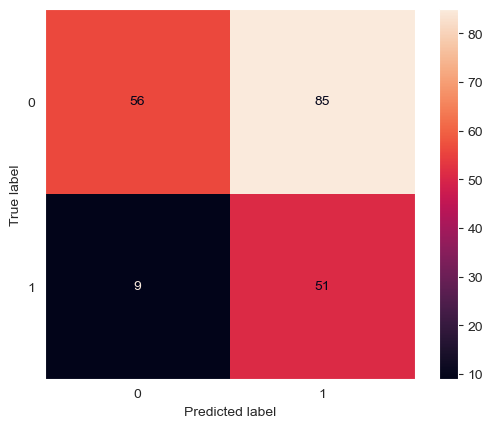

In [221]:
# Confusion Matrix for SVC

# Define confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
cf = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(7, 7))
cf.plot(cmap = 'rocket')
cf.ax_.grid(False)

# Show
plt.show()

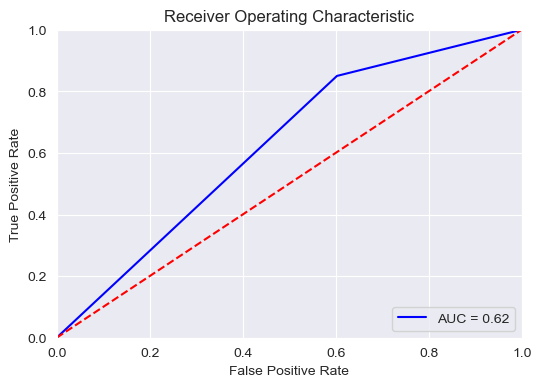

In [222]:
# ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize = (6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Show
plt.show()

## Hyperparameter tunning with GridSearchCV

In [267]:
# Define function
def model_gridsearch(model,name,X,y,grid_params):
    
    print('Currently fitting model:', model, '\n')
    
    # Stratified KFOLD
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # pipe define
    pipe = Pipeline(steps=[('preprocessing', preprocessor),
                           ('feature_selection', SelectKBest(f_classif)),
                          ('clf', model)])
    
    # gridsearch
    grid_pipe = GridSearchCV(pipe,grid_params, 
                             cv = skf, scoring='f1', 
                             n_jobs=-1, 
                             refit=True,
                             verbose = 0,
                             error_score = 'raise')
    
    # Fit 
    grid_pipe.fit(X,y)

    
    # evaluate
    print('Best Score:', grid_pipe.best_score_)
    print('Best Parameters:', grid_pipe.best_params_,'\n')
    
    return name,grid_pipe.best_score_,grid_pipe.best_params_

In [268]:
# Define models,parameters
models = [RandomForestClassifier(random_state=SEED), XGBClassifier(random_state=SEED), SVC(random_state=SEED)]
model_names = ['RF','XGB','SVC']

model_params = [
    {'feature_selection__k':[5,10,15,18],
     'clf__n_estimators': [5,10,15],
     'clf__criterion': ['gini','entropy'],
     'clf__max_depth': [2,3,5],
     'clf__class_weight': ['balanced']
    }, 
    
    {'feature_selection__k':[5,10,15,18],
     'clf__n_estimators': [5,10,15],
     'clf__max_depth': [2,3,5],
     'clf__subsample': [0.5,0.6],
     'clf__colsample_bytree': [0.5,0.6],
     'clf__gamma': [3,3.5,4]   
    },
    
    {'feature_selection__k':[5,10,15,18],
     'clf__kernel':['poly','rbf'],
     'clf__degree':[2,3],
     'clf__C': [0.04,0.041,0.042],
     'clf__class_weight':['balanced']  
    }]



# Call function
report = [] #list that will store results

for model,name,params in zip(models,model_names,model_params):
    name,score,params = model_gridsearch(model,name,X_train,y_train,params)
    report.append([name,score.round(3),params])

Currently fitting model: RandomForestClassifier(random_state=42) 

Best Score: 0.9328821430083074
Best Parameters: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__n_estimators': 10, 'feature_selection__k': 5} 

Currently fitting model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tr

## Results

In [269]:
# Results from Gridsearch
grid_results = pd.DataFrame(report, columns = ['Model', 'Score','Parameters'])
grid_results.sort_values(by = 'Score', ascending=False)

,Model,Score,Parameters
0,RF,0.933,"{'clf__class_weight': 'balanced', 'clf__criter..."
1,XGB,0.931,"{'clf__colsample_bytree': 0.5, 'clf__gamma': 3..."
2,SVC,0.522,"{'clf__C': 0.04, 'clf__class_weight': 'balance..."


In [264]:
# Results from manually search
manually_results = pd.DataFrame(results)
manually_results.sort_values(by = 'test score', ascending=False)

,model,test score,train score
0,RF_manually,0.932,0.937
1,XGB_manually,0.924,0.929
2,SVC_manually,0.520,0.522


## Final Conclusion:

From training the models both manually and with GridSearchCV, we observed similar results. However, there was a noticeable difference with the XGBoost model:

- **XGBoost Model**: 
  - GridSearchCV Result: 0.931
  - Manual Tuning Result: 0.929

Among the models tested, the **RandomForest** model emerged as the best performing one. This conclusion is based on its highest train and test scores, as obtained through GridSearchCV `0.933`.

## Prediction

In [308]:
X_new = pd.DataFrame({
    'checking_status':['0_checking','0_checking', '0_checking'],
    'duration' : [24,12,18],
    'credit_history': ['Delay_in_past','Existing_credits_paid_till_now','Existing_credits_paid_till_now'],
    'purpose': ['business', 'new_car','radio/television'],
    'credit_amount': [2745,5500,1500],
    'savings_status' : ['<100DM', '<100DM','Unknown_or_no_savings_acct'],
    'employment' : ['<1yr','1_to_4yrs', '<1yr'],
    'installment_commitment': [1,4,4],
    'personal_status' : ['female_divorced/separated/married','male_single', 'male_married/widowed'],
    'other_parties':['guarantor', 'co-applicant','guarantor'],
    'residence_since': [2,4,2],
    'property_magnitude': ['car_or_other_nonsavings','car_or_other_nonsavings', 'unknown/no_property'],
    'age':[27,33,25],
    'other_payment_plans':['none', 'none', 'stores'],
    'housing':['for_free', 'own','rent'],
    'existing_credits': [1,1,1],
    'job': ['skilled_employee/official','skilled_employee/official','unskilled_resident'],
    'num_dependents': [2,1,1],
    'own_telephone': ['yes','yes','yes'],
    'foreign_worker' : ['yes','yes','yes']})

In [309]:
X_new

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0_checking,24,Delay_in_past,business,2745,<100DM,<1yr,1,female_divorced/separated/married,guarantor,2,car_or_other_nonsavings,27,none,for_free,1,skilled_employee/official,2,yes,yes
1,0_checking,12,Existing_credits_paid_till_now,new_car,5500,<100DM,1_to_4yrs,4,male_single,co-applicant,4,car_or_other_nonsavings,33,none,own,1,skilled_employee/official,1,yes,yes
2,0_checking,18,Existing_credits_paid_till_now,radio/television,1500,Unknown_or_no_savings_acct,<1yr,4,male_married/widowed,guarantor,2,unknown/no_property,25,stores,rent,1,unskilled_resident,1,yes,yes


In [310]:
# Final pipeline
final_model = Pipeline(steps=[('preprocessing', preprocessor),
                              ('feature_selection', SelectKBest(f_classif, k=5)),
                              ('clf', RandomForestClassifier(n_estimators = 10, max_depth = 5,
                                                            criterion = 'gini', class_weight = 'balanced', random_state = 42))])

# Fit
final_model.fit(X_train,y_train)

# Predict
predictions = final_model.predict(X_new)

# Print predictions
print(predictions)

[0 1 0]


### Predictions are true!